# notebook intialization
This notebook can be used in two ways:

1. **Full training**: Train all models from scratch on CIFAR-100 and CIFAR-10.
2. **Evaluation-only**: Load pre-trained model weights and history files and only run the testing and visualization sections.

Please choose one mode:

- If you want to **train from scratch** (it takes time), uncomment the models saving lines and run all cells in the sections:
  - `Data preprocessing pipeline`
  - `CIFAR-100 model training`
  - `CIFAR-10 model training`
  - `Models testing`
  - `Models evaluation`

- If you want to **use pre-trained artifacts**, make sure the `artifacts/models` and `artifacts/histories` folders are present as described in the README, then skip the training sections and start from the `Models testing` section.

In [24]:
import os

# Choose mode:
# - True  = use pre-trained models & histories (if available)
# - False = train everything from scratch and save artifacts
USE_PRETRAINED = False

# Base artifacts directory (relative to the repo root)
ARTIFACTS_DIR = "artifacts"
MODELS_DIR = os.path.join(ARTIFACTS_DIR, "models")
HISTORIES_DIR = os.path.join(ARTIFACTS_DIR, "histories")

# Make sure directories exist when saving
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)


# data preprocessing pipline

---



In [25]:
#Uncomment for google colab users only
#pip install --upgrade tensorflow


In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import layers, regularizers, applications, models, losses, optimizers, callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
import tensorflow_hub as hub
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import os
from matplotlib.colors import to_rgba

In [27]:

IMG_SIZE = 32
BATCH_SIZE = 128

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,
    with_info=True
)

CIFAR100_MEAN = tf.constant([0.5071, 0.4867, 0.4408])[None, None, :]
CIFAR100_STD  = tf.constant([0.2675, 0.2565, 0.2761])[None, None, :]

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - CIFAR100_MEAN) / CIFAR100_STD
    return image, label


data_train = (ds_train.map(preprocess).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
data_val = (ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
data_test = (ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

class_names = ds_info.features['label'].names


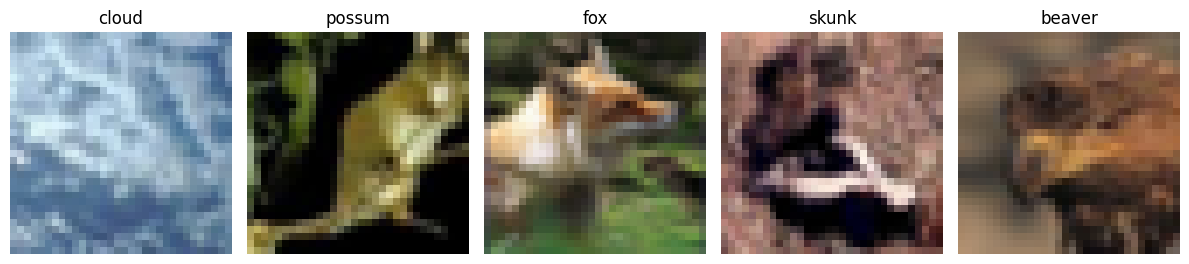

In [28]:

def denormalize(image):
    return image * CIFAR100_STD + CIFAR100_MEAN

# Visualize 5 images
for images, labels in data_train.take(1):
    images = denormalize(images)
    plt.figure(figsize=(12, 3))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# models training

---



## layers based models trials

### First model








in this section the we have the simplest CNN architecture only adding more layers without using any of the normalization techinques

for the first model we notice a very clear overfitting problem but instead of solving it with normalization and fine-tunning we only increase the number of layers for triall purposes

In [67]:

model1 = Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(100, activation='softmax')  # 100 classes
])


In [68]:
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [69]:
history1 = model1.fit(
    data_train,
    validation_data=data_val,
    epochs=15
)
if not USE_PRETRAINED:
    model1.save(os.path.join(MODELS_DIR, "model1_cifar100.keras"))

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.0512 - loss: 4.2455 - val_accuracy: 0.1948 - val_loss: 3.3435
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2296 - loss: 3.1740 - val_accuracy: 0.2962 - val_loss: 2.7810
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3492 - loss: 2.5389 - val_accuracy: 0.3590 - val_loss: 2.5293
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4466 - loss: 2.0797 - val_accuracy: 0.4096 - val_loss: 2.2960
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5334 - loss: 1.7023 - val_accuracy: 0.4250 - val_loss: 2.3164
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6203 - loss: 1.3454 - val_accuracy: 0.4180 - val_loss: 2.4007
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7009 - loss: 1.0275 - val_accuracy: 0.4146 - val_loss: 2.6474
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7765 - loss: 0.7443 - val_accuracy: 

In [70]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "model1_history.npy"), history1.history)

In [71]:

model1_no_overfitting = Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.3),


    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(100, activation='softmax')
])


In [72]:
model1_no_overfitting.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [73]:
history_model1_no_overfitting = model1_no_overfitting.fit(
    data_train,
    validation_data=data_val,
    epochs=15
)
if not USE_PRETRAINED:
    model1_no_overfitting.save(os.path.join(MODELS_DIR, "model1_cifar100_no_overfitting.keras"))

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.0461 - loss: 4.5057 - val_accuracy: 0.0914 - val_loss: 3.9893
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1278 - loss: 3.7365 - val_accuracy: 0.2012 - val_loss: 3.3139
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1869 - loss: 3.3424 - val_accuracy: 0.2900 - val_loss: 2.8147
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2530 - loss: 2.9775 - val_accuracy: 0.3334 - val_loss: 2.6087
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3118 - loss: 2.6870 - val_accuracy: 0.3662 - val_loss: 2.3957
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3579 - loss: 2.4561 - val_accuracy: 0.4072 - val_loss: 2.2455
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3907 - loss: 2.2946 - val_accuracy: 0.4074 - val_loss: 2.2596
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4206 - loss: 2.1456 - val_accuracy: 

In [74]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "model1_cifar100_no_overfitting_history.npy"), history_model1_no_overfitting.history)

### second model
















by increasing the layers of the model the performance significantally decreases the model almost learns nothing from the training process

In [75]:

model2 = Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(100, activation='softmax')
])


In [76]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [77]:
history2 = model2.fit(
    data_train,
    validation_data=data_val,
    epochs=15
)
if not USE_PRETRAINED:
    model2.save(os.path.join(MODELS_DIR, "model2_cifar100.keras"))

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.0218 - loss: 4.4611 - val_accuracy: 0.0752 - val_loss: 3.9811
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0928 - loss: 3.8594 - val_accuracy: 0.1530 - val_loss: 3.5247
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1728 - loss: 3.4306 - val_accuracy: 0.2090 - val_loss: 3.2773
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2418 - loss: 3.0685 - val_accuracy: 0.2488 - val_loss: 3.0387
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2969 - loss: 2.7784 - val_accuracy: 0.2838 - val_loss: 2.9163
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3534 - loss: 2.5082 - val_accuracy: 0.3086 - val_loss: 2.8439
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4088 - loss: 2.2380 - val_accuracy: 0.3160 - val_loss: 2.8824
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4794 - loss: 1.9383 - val_accurac

In [78]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "model2_history.npy"), history2.history)

## improved models trials






### First model



In [79]:

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.resize_with_crop_or_pad(image, 36, 36)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    return image, label

augmented_train = (ds_train
                   .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                   .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                   .shuffle(10000)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.AUTOTUNE))

In [80]:

def improved_model(num_classes=100, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='improved_model_functional')
    return model
model = improved_model(num_classes=100)

In [81]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


In [82]:
history = model.fit(
    augmented_train,
    validation_data=data_val,
    epochs=200,
    callbacks=[lr_scheduler, early_stop]
)
if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "improved_model.keras"))


Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.0453 - loss: 6.1490 - val_accuracy: 0.1308 - val_loss: 4.5913 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1298 - loss: 4.4800 - val_accuracy: 0.1776 - val_loss: 3.9304 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2148 - loss: 3.7336 - val_accuracy: 0.2552 - val_loss: 3.4947 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2676 - loss: 3.4099 - val_accuracy: 0.3010 - val_loss: 3.2185 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3158 - loss: 3.2137 - val_accuracy: 0.3728 - val_loss: 2.9655 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3583 - loss: 3.0657 - val_accuracy: 0.4054 - val_loss: 2.9018 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3903 - 

In [83]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "improved_model_history.npy"), history.history)

### second model



In [84]:
BATCH_SIZE = 32

def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 4, IMG_SIZE + 4)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

augmented_train = (ds_train
                   .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                   .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                   .shuffle(10000)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.AUTOTUNE))

In [85]:
def model3(num_classes=100, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(100, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="model3")
    return model
model3 = model3(num_classes=100)


In [86]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)



In [87]:
history3 = model3.fit(
    augmented_train,
    validation_data=data_val,
    epochs=200,
    callbacks=[lr_scheduler, early_stop]
)

if not USE_PRETRAINED:
    model3.save(os.path.join(MODELS_DIR, "model3.keras"))


Epoch 1/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.0781 - loss: 4.6168 - val_accuracy: 0.2102 - val_loss: 3.7197 - learning_rate: 0.0010
Epoch 2/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2139 - loss: 3.6708 - val_accuracy: 0.3082 - val_loss: 3.1826 - learning_rate: 0.0010
Epoch 3/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2890 - loss: 3.3198 - val_accuracy: 0.3624 - val_loss: 3.0240 - learning_rate: 0.0010
Epoch 4/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3387 - loss: 3.1754 - val_accuracy: 0.4078 - val_loss: 2.9059 - learning_rate: 0.0010
Epoch 5/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3698 - loss: 3.0815 - val_accuracy: 0.4248 - val_loss: 2.8840 - learning_rate: 0.0010
Epoch 6/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3969 - loss: 3.0111 - val_accuracy: 0.4438 - val_loss: 2.8141 - learning_rate: 0.0010
Epoch 7/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0

In [88]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "model3_history.npy"), history3.history)

## pre-trained models trials

### first model



In [89]:

def preprocess_efficientnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.efficientnet.preprocess_input(image)
    return image, label

BATCH_SIZE = 64


train_ds = (ds_train
            .map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (ds_val
          .map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))


base_model = applications.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)


base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "efficientnetb7_cifar100.keras"))

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 211s 191ms/step - accuracy: 0.5165 - loss: 2.0025 - val_accuracy: 0.7142 - val_loss: 0.9770
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.6957 - loss: 1.0663 - val_accuracy: 0.7276 - val_loss: 0.9128
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.7308 - loss: 0.9198 - val_accuracy: 0.7374 - val_loss: 0.8891
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.7500 - loss: 0.8406 - val_accuracy: 0.7462 - val_loss: 0.8914
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.7713 - loss: 0.7569 - val_accuracy: 0.7494 - val_loss: 0.8768
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.7852 - loss: 0.7023 - val_accuracy: 0.7538 - val_loss: 0.8841
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.8011 - loss: 0.6451 - val_accuracy: 0.7546 - val_loss: 0.8950
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.8081 - loss: 0.6156 

In [90]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "efficientnetb7_cifar100_history.npy"), history.history)

### second model



In [91]:

def preprocess_resnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.resnet.preprocess_input(image)
    return image, label

BATCH_SIZE = 64

train_ds = (ds_train
            .map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (ds_val
          .map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)


base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(train_ds, validation_data=val_ds, epochs=20)



if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "resnet50_cifar100.keras"))

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step - accuracy: 0.3719 - loss: 2.5875 - val_accuracy: 0.6502 - val_loss: 1.1951
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6050 - loss: 1.3924 - val_accuracy: 0.6746 - val_loss: 1.1017
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6425 - loss: 1.2246 - val_accuracy: 0.6878 - val_loss: 1.0586
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6661 - loss: 1.1416 - val_accuracy: 0.6952 - val_loss: 1.0497
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6892 - loss: 1.0600 - val_accuracy: 0.7032 - val_loss: 1.0185
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6977 - loss: 1.0048 - val_accuracy: 0.7088 - val_loss: 1.0054
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.7194 - loss: 0.9261 - val_accuracy: 0.7122 - val_loss: 1.0187
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.7273 - loss: 0.8923 - 

In [92]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "resnet50_cifar100_history.npy"), history.history)

In [93]:

def preprocess_resnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.resnet50.preprocess_input(image)
    return image, label

BATCH_SIZE = 64

train_ds = (ds_train
            .map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (ds_val
          .map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[lr_scheduler, early_stop]
)


if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "resnet50_cifar100_50epochs.keras"))

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.3887 - loss: 2.5548 - val_accuracy: 0.6390 - val_loss: 1.2885 - learning_rate: 0.0010
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5853 - loss: 1.5002 - val_accuracy: 0.6600 - val_loss: 1.1729 - learning_rate: 0.0010
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6349 - loss: 1.2894 - val_accuracy: 0.6748 - val_loss: 1.1432 - learning_rate: 0.0010
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6647 - loss: 1.1740 - val_accuracy: 0.6894 - val_loss: 1.0913 - learning_rate: 0.0010
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6843 - loss: 1.0828 - val_accuracy: 0.6938 - val_loss: 1.0903 - learning_rate: 0.0010
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.7028 - loss: 1.0180 - val_accuracy: 0.7020 - val_loss: 1.0669 - learning_rate: 0.0010
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.7150 - l

In [94]:

if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "resnet50_cifar100_50epochs_history.npy"), history.history)

## cifar10 trainings

In [95]:

IMG_SIZE = 32
BATCH_SIZE = 128

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,
    with_info=True
)


CIFAR10_MEAN = tf.constant([0.4914, 0.4822, 0.4465])[None, None, :]
CIFAR10_STD = tf.constant([0.2470, 0.2435, 0.2616])[None, None, :]

def preprocess_cifar10(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - CIFAR10_MEAN) / CIFAR10_STD
    return image, label


data_train = (ds_train
              .map(preprocess_cifar10, num_parallel_calls=tf.data.AUTOTUNE)
              .shuffle(10000)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))

data_val = (ds_val
            .map(preprocess_cifar10, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

data_test = (ds_test
             .map(preprocess_cifar10, num_parallel_calls=tf.data.AUTOTUNE)
             .batch(BATCH_SIZE)
             .prefetch(tf.data.AUTOTUNE))
class_names = ds_info.features['label'].names

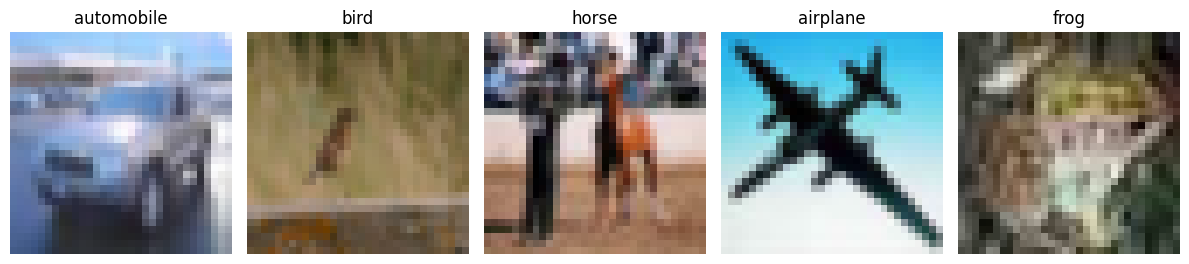

In [96]:
def denormalize_cifar10(image):
    return tf.clip_by_value(image * CIFAR10_STD + CIFAR10_MEAN, 0.0, 1.0)

for images, labels in data_train.take(1):
    images = denormalize_cifar10(images)
    plt.figure(figsize=(12, 3))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [97]:
BATCH_SIZE = 128
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.resize_with_crop_or_pad(image, 36, 36)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    return image, label

augmented_train = (ds_train
                   .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                   .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                   .shuffle(10000)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.AUTOTUNE))

In [98]:
def improved_model_cifar10(num_classes=10, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(5e-4))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='improved_model_cifar10')
    return model

model = improved_model_cifar10()

In [99]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


In [100]:
history = model.fit(
    augmented_train,
    validation_data=data_val,
    epochs=200,
    callbacks=[lr_scheduler, early_stop]
)

if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "improved_model_cifar10.keras"))

Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.3474 - loss: 3.6352 - val_accuracy: 0.5618 - val_loss: 2.2865 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5681 - loss: 2.1431 - val_accuracy: 0.6206 - val_loss: 1.7734 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6602 - loss: 1.6050 - val_accuracy: 0.6898 - val_loss: 1.4799 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7278 - loss: 1.3790 - val_accuracy: 0.7630 - val_loss: 1.2561 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7535 - loss: 1.2893 - val_accuracy: 0.7736 - val_loss: 1.2316 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7781 - loss: 1.2146 - val_accuracy: 0.7766 - val_loss: 1.2014 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7924 - 

In [101]:

if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "improved_model_cifar10_history.npy"), history.history)

In [102]:
BATCH_SIZE=32

In [103]:
def model3_cifar10(num_classes=10, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # ✅ changed to num_classes

    model3_cifar10 = models.Model(inputs=inputs, outputs=outputs, name="model3_cifar10")
    return model3_cifar10
model3_cifar10 = model3_cifar10(num_classes=10)
model3_cifar10.summary()

Model: "model3_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,960,842 (18.92 MB)

 Trainable params: 4,957,002 (18.91 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [104]:

model3_cifar10.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)




In [105]:

history3_cifar10 = model3_cifar10.fit(
    augmented_train,
    validation_data=data_val,
    epochs=200,
    callbacks=[lr_scheduler, early_stop]
)
model3_cifar10.save('model3_cifar10.keras')

if not USE_PRETRAINED:
    model3_cifar10.save(os.path.join(MODELS_DIR, "model3_cifar10.keras"))

Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.3760 - loss: 2.1758 - val_accuracy: 0.6060 - val_loss: 1.6453 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6271 - loss: 1.5073 - val_accuracy: 0.7186 - val_loss: 1.2305 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7029 - loss: 1.2614 - val_accuracy: 0.7772 - val_loss: 1.0215 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7491 - loss: 1.1204 - val_accuracy: 0.7838 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7673 - loss: 1.0468 - val_accuracy: 0.7974 - val_loss: 0.9589 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7852 - loss: 0.9879 - val_accuracy: 0.8138 - val_loss: 0.9174 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8027 - loss: 

In [106]:

if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "model3_cifar10_history.npy"), history3_cifar10.history)

In [107]:

(ds_train, ds_val), ds_info = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names

def preprocess_efficientnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.efficientnet.preprocess_input(image)
    return image, label

BATCH_SIZE = 64

train_ds = (ds_train
            .map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (ds_val
          .map(preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

base_model = applications.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "efficientnetb7_cifar10.keras"))

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 206s 187ms/step - accuracy: 0.8693 - loss: 0.4207 - val_accuracy: 0.9202 - val_loss: 0.2429
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9168 - loss: 0.2477 - val_accuracy: 0.9236 - val_loss: 0.2269
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9308 - loss: 0.2104 - val_accuracy: 0.9264 - val_loss: 0.2241
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9352 - loss: 0.1889 - val_accuracy: 0.9288 - val_loss: 0.2293
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9437 - loss: 0.1640 - val_accuracy: 0.9310 - val_loss: 0.2167
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9480 - loss: 0.1517 - val_accuracy: 0.9324 - val_loss: 0.2281
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9539 - loss: 0.1344 - val_accuracy: 0.9318 - val_loss: 0.2306
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9577 - loss: 0.1229 

In [108]:

if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "efficientnetb7_cifar10_history.npy"), history.history)

In [109]:
def preprocess_resnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.resnet.preprocess_input(image)
    return image, label

BATCH_SIZE = 64

train_ds = (ds_train
            .map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (ds_val
          .map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))


base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

if not USE_PRETRAINED:
    model.save(os.path.join(MODELS_DIR, "resnet50_cifar10.keras"))



Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - accuracy: 0.7875 - loss: 0.6472 - val_accuracy: 0.8902 - val_loss: 0.3103
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.8715 - loss: 0.3672 - val_accuracy: 0.9052 - val_loss: 0.2670
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.8929 - loss: 0.3154 - val_accuracy: 0.9092 - val_loss: 0.2616
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9015 - loss: 0.2891 - val_accuracy: 0.9076 - val_loss: 0.2696
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9062 - loss: 0.2698 - val_accuracy: 0.9118 - val_loss: 0.2698
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9133 - loss: 0.2537 - val_accuracy: 0.9120 - val_loss: 0.2615
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9172 - loss: 0.2365 - val_accuracy: 0.9124 - val_loss: 0.2701
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9177 - loss: 0.2317 - 

In [110]:
if not USE_PRETRAINED:
    np.save(os.path.join(HISTORIES_DIR, "resnet50_cifar10_history.npy"), history.history)

# models testing

---




--- model1 ---


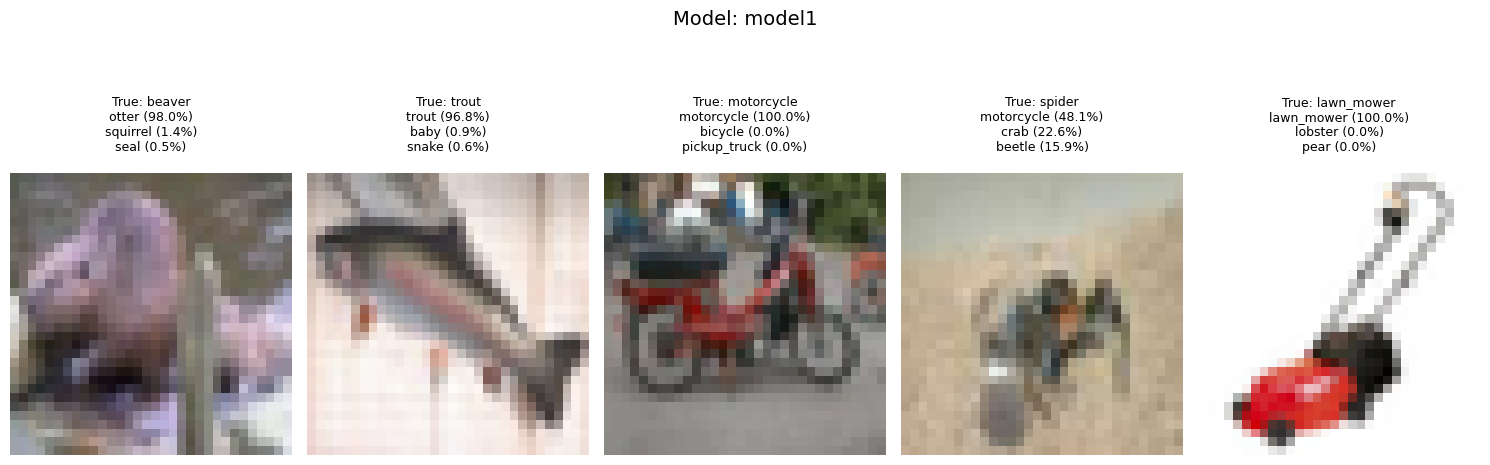


--- model1_no_overfitting ---


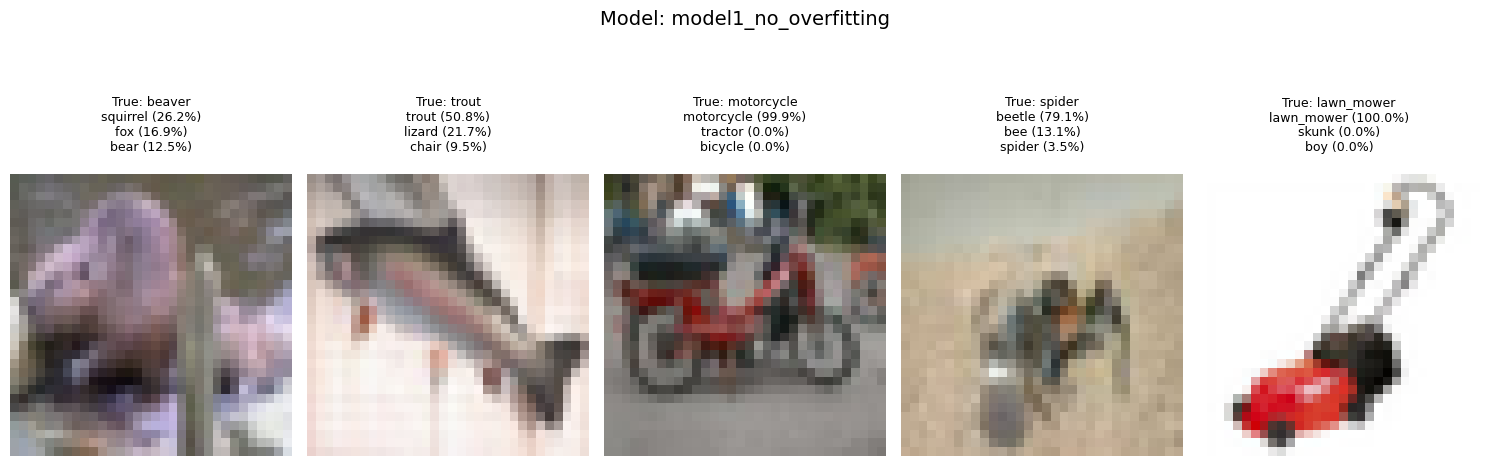


--- model2 ---


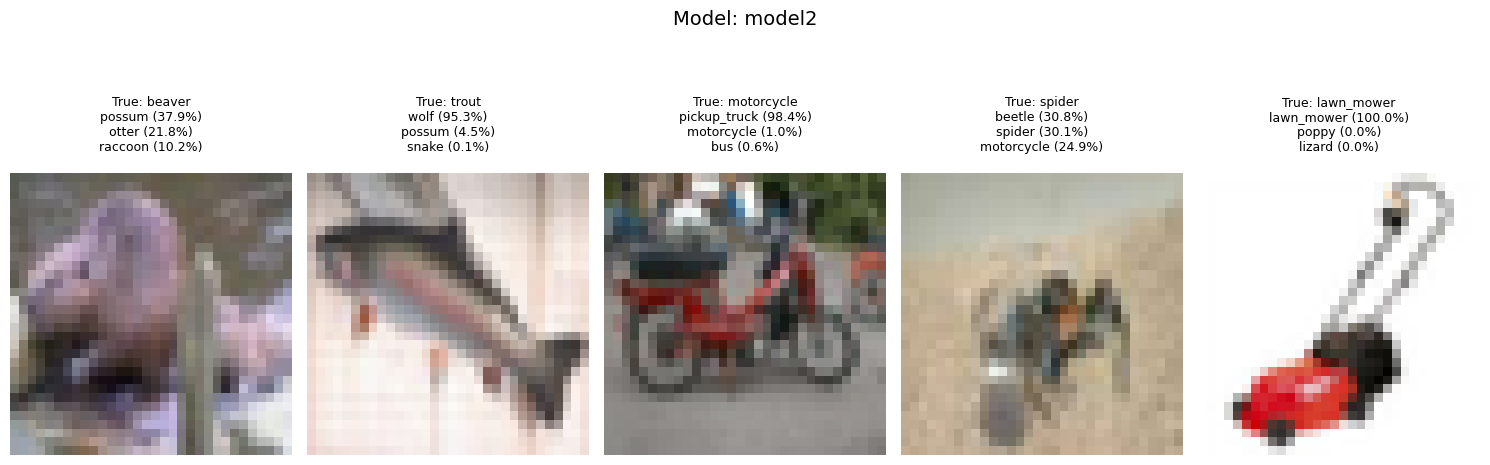


--- improved_model ---


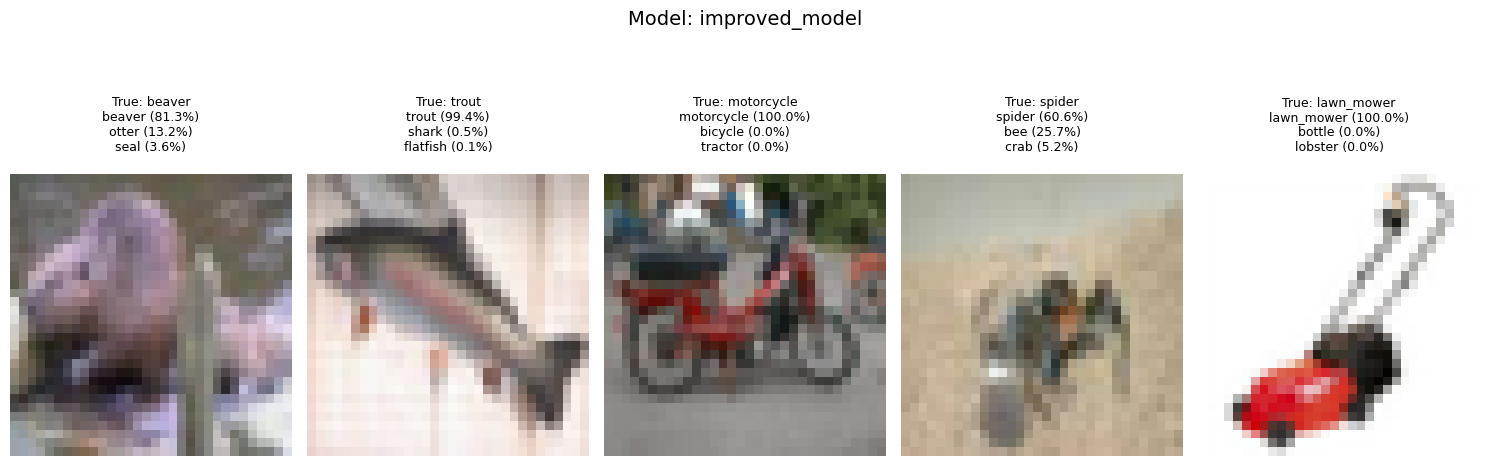


--- model3 ---


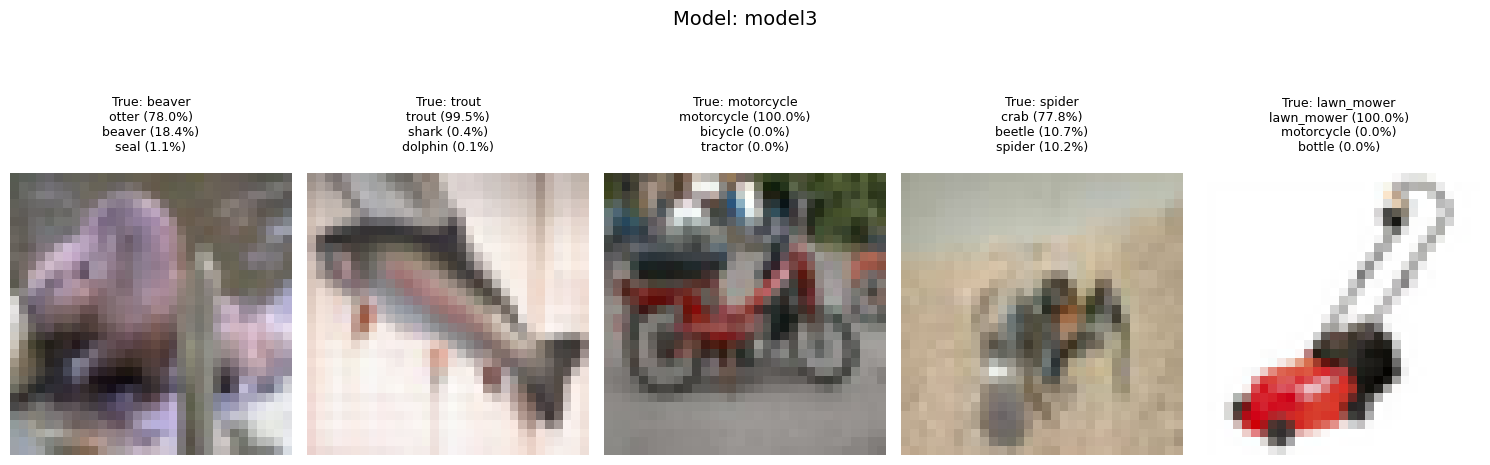


--- efficientnetb7 ---


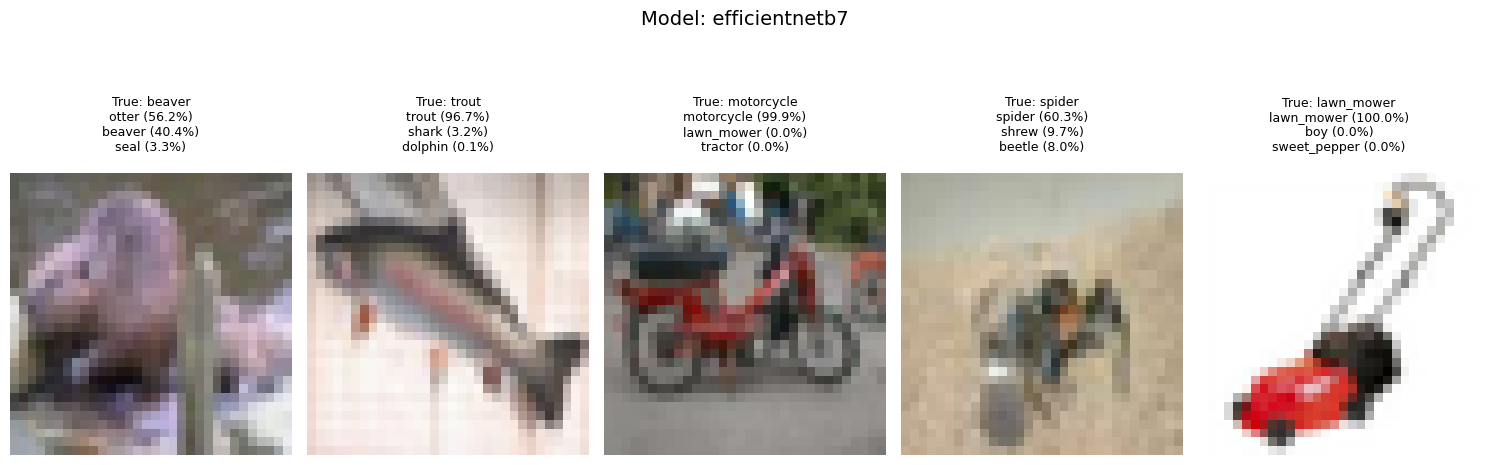


--- resnet50 ---


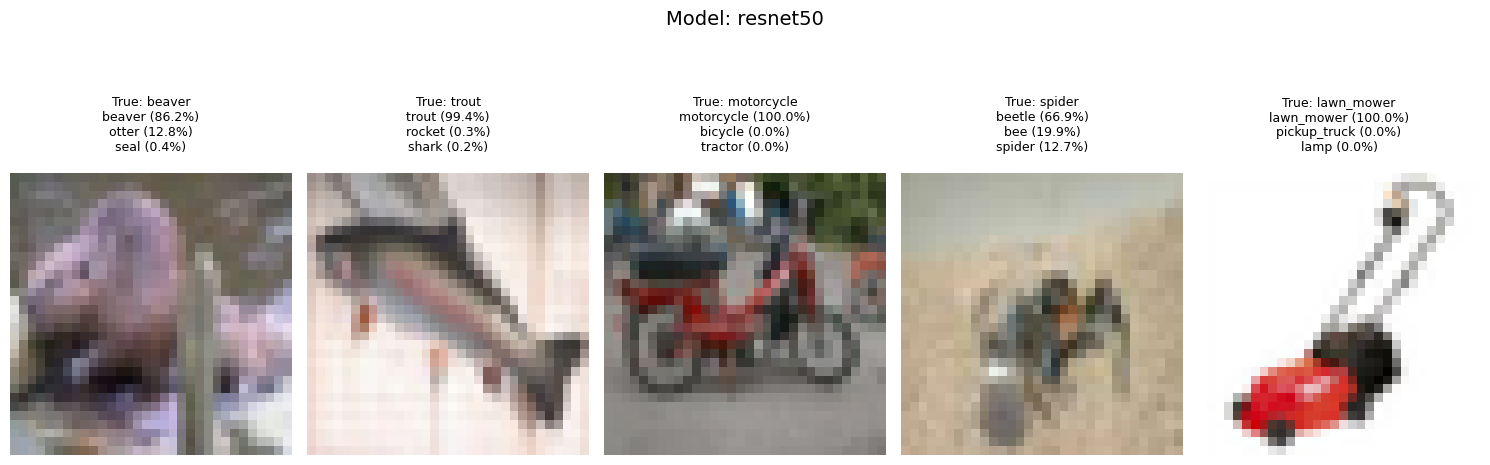


--- resnet50_50epochs ---


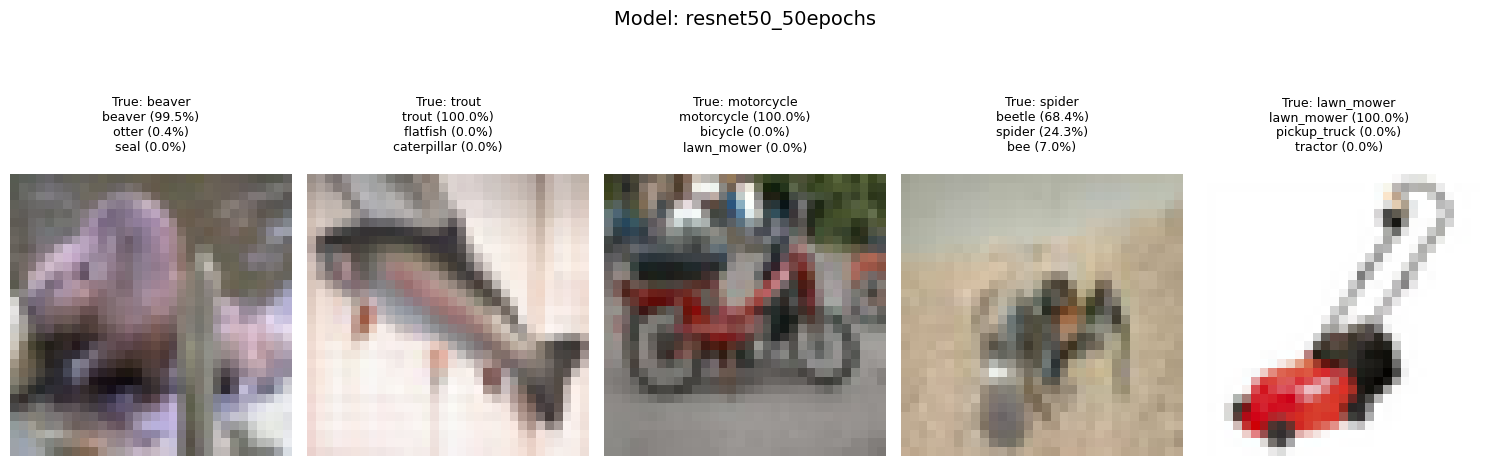

In [29]:
# CIFAR-100 test set and helper functions for visualizing predictions
ds_test, ds_info = tfds.load(
    'cifar100',
    split='test',
    with_info=True,
    as_supervised=True
)

class_names = ds_info.features['label'].names

def preprocess_original(image, label):
    # Normalize with CIFAR-100 mean/std used in training
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - tf.constant([0.5071, 0.4867, 0.4408])) / tf.constant([0.2675, 0.2565, 0.2761])
    return image, label

def preprocess_efficientnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def preprocess_resnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image, label

def get_random_test_images(num_samples=5):
    ds_sample = ds_test.shuffle(1000).take(num_samples)
    images, labels = [], []
    for img, label in ds_sample:
        images.append(img)
        labels.append(label)
    return images, labels

def show_predictions(model, preprocess_fn, model_name, test_images, test_labels):
    print(f"\n--- {model_name} ---")
    plt.figure(figsize=(15, 6))
    for i in range(len(test_images)):
        img = test_images[i]
        true_label = class_names[test_labels[i].numpy()]

        # Preprocess and run prediction
        img_proc, _ = preprocess_fn(img, test_labels[i])
        input_tensor = tf.expand_dims(img_proc, 0)
        predictions = model.predict(input_tensor, verbose=0)[0]

        top3_idx = predictions.argsort()[-3:][::-1]
        top3_probs = predictions[top3_idx] * 100
        top3_classes = [class_names[j] for j in top3_idx]

        plt.subplot(1, len(test_images), i + 1)
        plt.imshow(tf.cast(img, tf.uint8))
        plt.axis('off')
        pred_text = f"True: {true_label}\n"
        for j in range(3):
            pred_text += f"{top3_classes[j]} ({top3_probs[j]:.1f}%)\n"
        plt.title(pred_text, fontsize=9)

    plt.suptitle(f"Model: {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Paths to saved CIFAR-100 models
model_paths = {
    "model1":               os.path.join(MODELS_DIR, "model1_cifar100.keras"),
    "model1_no_overfitting": os.path.join(MODELS_DIR, "model1_cifar100_no_overfitting.keras"),
    "model2":               os.path.join(MODELS_DIR, "model2_cifar100.keras"),
    "improved_model":       os.path.join(MODELS_DIR, "improved_model.keras"),
    "model3":               os.path.join(MODELS_DIR, "model3.keras"),
    "efficientnetb7":       os.path.join(MODELS_DIR, "efficientnetb7_cifar100.keras"),
    "resnet50":             os.path.join(MODELS_DIR, "resnet50_cifar100.keras"),
    "resnet50_50epochs":    os.path.join(MODELS_DIR, "resnet50_cifar100_50epochs.keras"),
}

preprocess_map = {
    "model1":               preprocess_original,
    "model1_no_overfitting": preprocess_original,
    "model2":               preprocess_original,
    "improved_model":       preprocess_original,
    "model3":               preprocess_original,
    "efficientnetb7":       preprocess_efficientnet,
    "resnet50":             preprocess_resnet,
    "resnet50_50epochs":    preprocess_resnet,
}


if not USE_PRETRAINED:
    print("Warning: USE_PRETRAINED is False. "
          "This cell expects saved model files in MODELS_DIR. "
          "Make sure you trained and saved the models before running this.")

random_images, random_labels = get_random_test_images(num_samples=5)

for name, path in model_paths.items():
    if os.path.exists(path):
        model = load_model(path)
        preprocess_fn = preprocess_map[name]
        show_predictions(model, preprocess_fn, name, random_images, random_labels)
    else:
        print(f"Model file not found for {name}. Expected at: {path}")


In [30]:
test_accuracies = {}

for name, path in model_paths.items():
    # Make sure we have a preprocessing function defined
    if name not in preprocess_map:
        print(f"Skipping {name} — no preprocessing function.")
        continue

    # Make sure the model file actually exists
    if not os.path.exists(path):
        print(f"Skipping {name} — model file not found at: {path}")
        continue

    print(f"\nEvaluating model: {name}")
    model = load_model(path)
    preprocess_fn = preprocess_map[name]

    ds_processed = ds_test.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds_processed = ds_processed.batch(128).prefetch(tf.data.AUTOTUNE)

    loss, acc = model.evaluate(ds_processed, verbose=0)
    test_accuracies[name] = acc
    print(f"Test Accuracy: {acc:.4f}")

print("\n=== Final Test Accuracies ===")
for name, acc in test_accuracies.items():
    print(f"{name}: {acc:.4f}")



Evaluating model: model1
Test Accuracy: 0.4213

Evaluating model: model1_no_overfitting
Test Accuracy: 0.5299

Evaluating model: model2
Test Accuracy: 0.3140

Evaluating model: improved_model
Test Accuracy: 0.7099

Evaluating model: model3
Test Accuracy: 0.7237

Evaluating model: efficientnetb7
Test Accuracy: 0.7492

Evaluating model: resnet50
Test Accuracy: 0.7230

Evaluating model: resnet50_50epochs
Test Accuracy: 0.7470

=== Final Test Accuracies ===
model1: 0.4213
model1_no_overfitting: 0.5299
model2: 0.3140
improved_model: 0.7099
model3: 0.7237
efficientnetb7: 0.7492
resnet50: 0.7230
resnet50_50epochs: 0.7470


you can change the classes with the following for more predictions


*   ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree']
*   ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']

*   ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']
*  ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']










=== MODEL1 ===


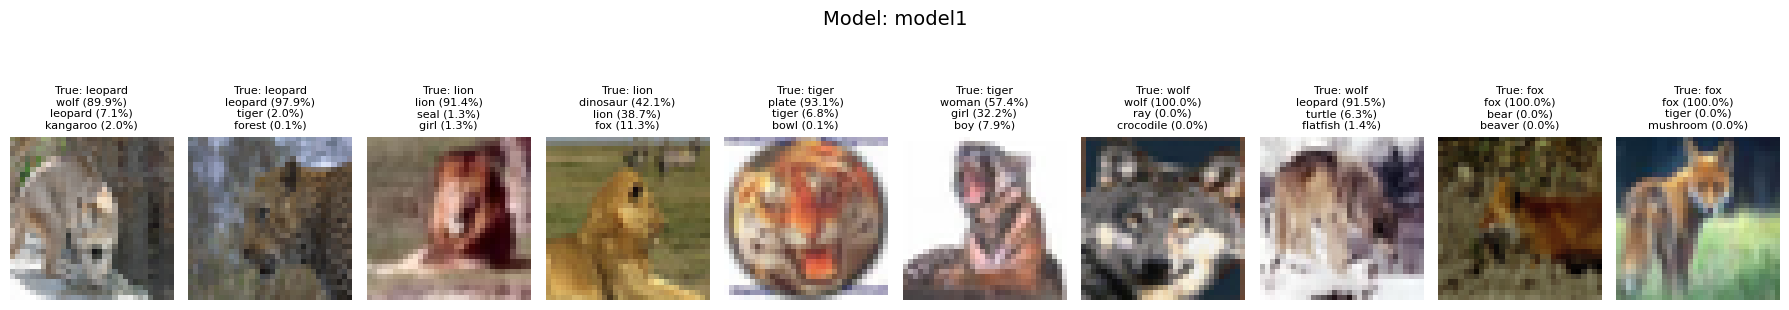


=== MODEL1_NO_OVERFITTING ===


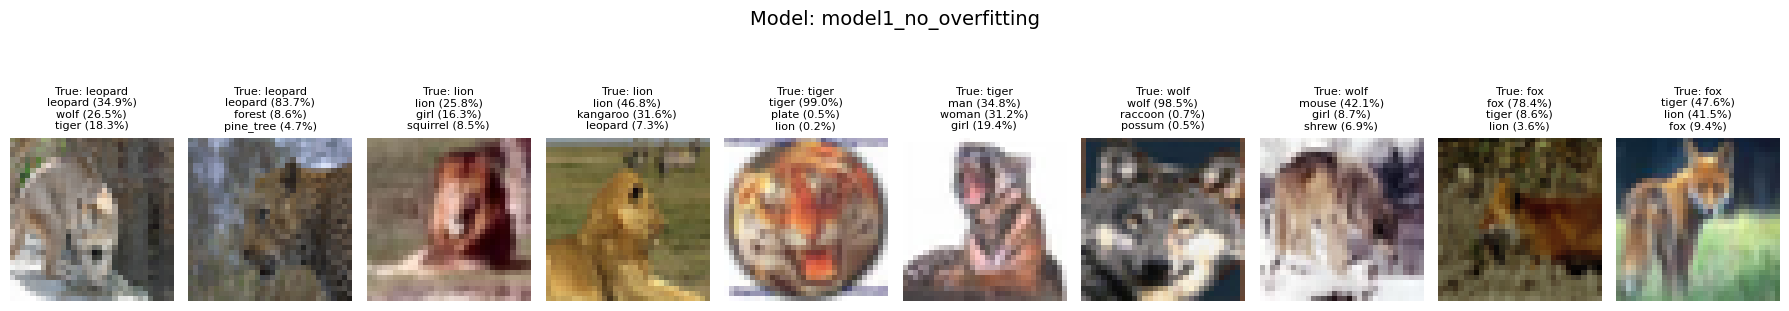


=== MODEL2 ===


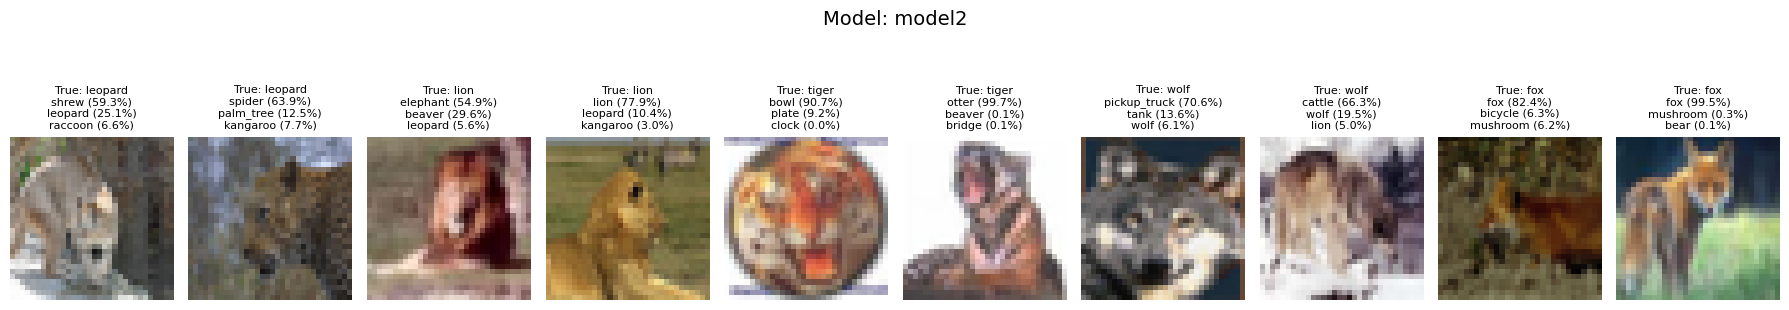


=== IMPROVED_MODEL ===


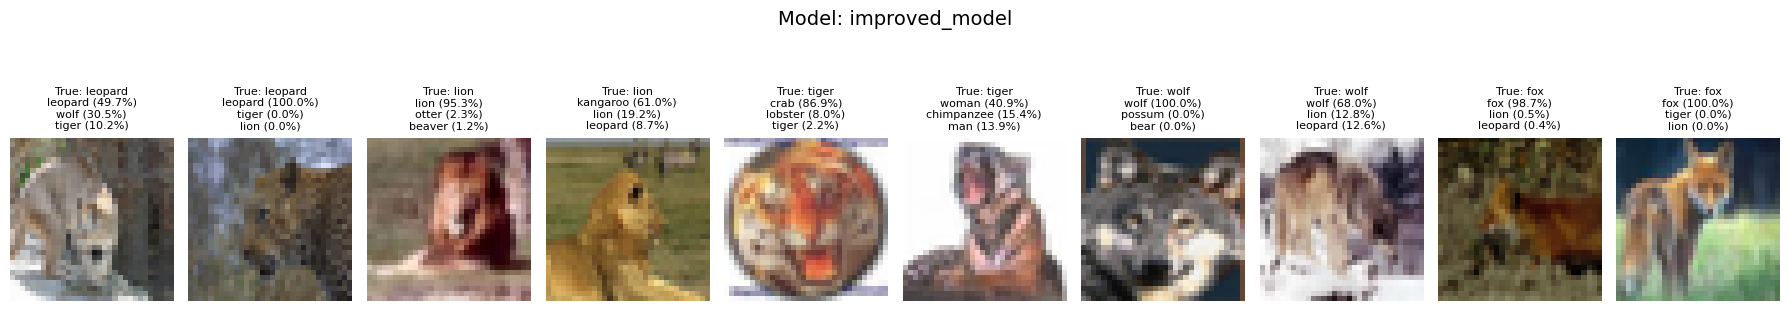


=== MODEL3 ===


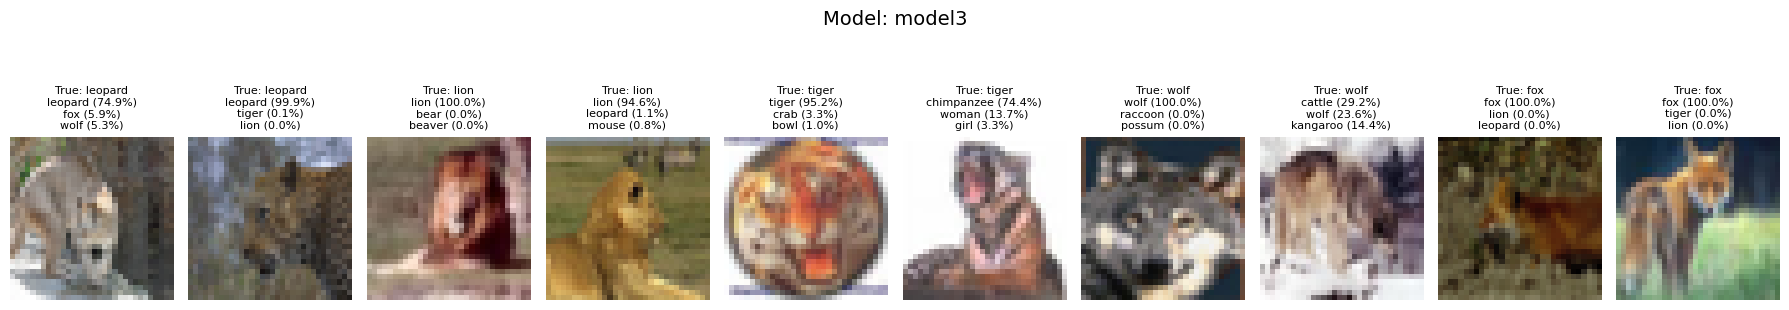


=== EFFICIENTNETB7 ===


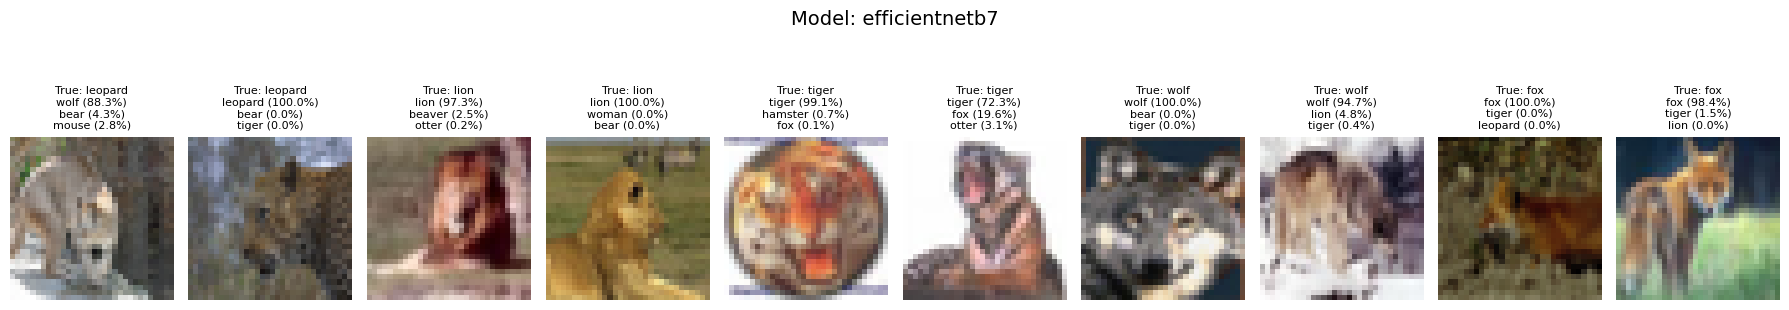


=== RESNET50 ===


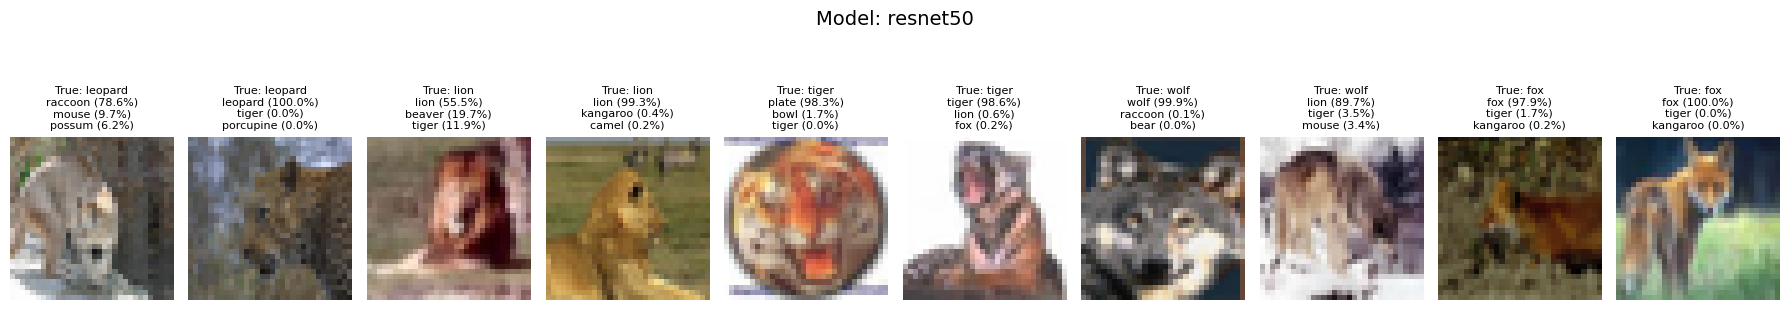


=== RESNET50_50EPOCHS ===


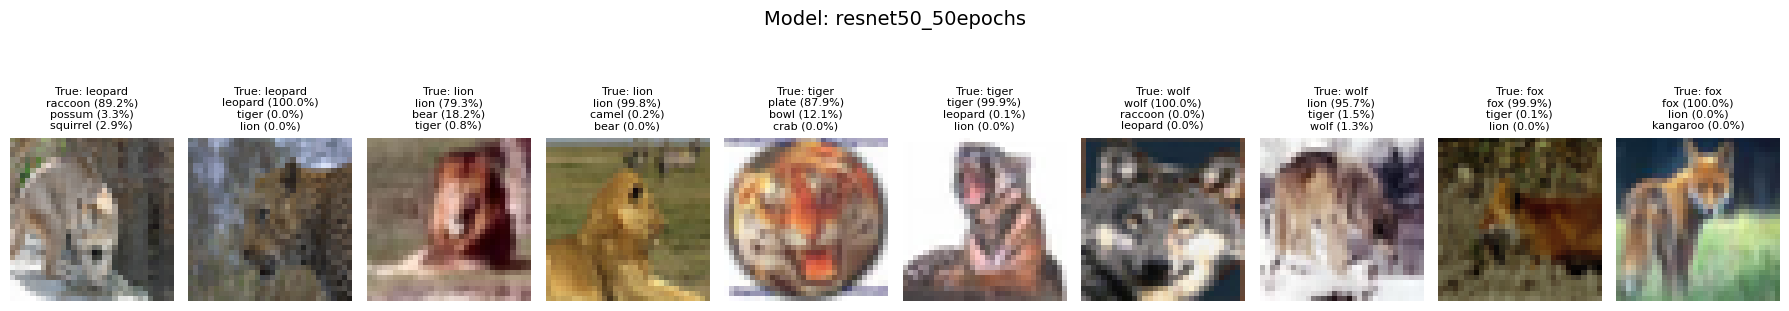

In [31]:
similar_classes = ['leopard', 'lion', 'tiger', 'wolf', 'fox']
similar_indices = [class_names.index(c) for c in similar_classes]

def get_random_samples_per_class(class_indices, samples_per_class=2):
    images, labels = [], []
    for idx in class_indices:
        # Filter test set for the given class and sample a few images
        filtered = ds_test.filter(lambda img, lbl: lbl == idx).shuffle(1000).take(samples_per_class)
        for img, lbl in tfds.as_numpy(filtered):
            images.append(img)
            labels.append(lbl)
    return images, labels

def show_all_model_predictions(models, preprocess_map, test_images, test_labels):
    for model_name, model_path in models.items():
        # Skip models without a preprocessing function
        if model_name not in preprocess_map:
            print(f"Skipping {model_name} — no preprocessing function defined.")
            continue

        # Skip models whose file does not exist
        if not os.path.exists(model_path):
            print(f"Skipping {model_name} — model file not found at: {model_path}")
            continue

        print(f"\n=== {model_name.upper()} ===")
        model = load_model(model_path)
        preprocess_fn = preprocess_map[model_name]

        plt.figure(figsize=(18, 4))
        for i in range(len(test_images)):
            img = test_images[i]
            label = test_labels[i]
            true_label = class_names[label]

            # Preprocess and predict
            img_proc, _ = preprocess_fn(img, label)
            input_tensor = tf.expand_dims(img_proc, 0)

            preds = model.predict(input_tensor, verbose=0)[0]
            top3_idx = preds.argsort()[-3:][::-1]
            top3_probs = preds[top3_idx] * 100
            top3_labels = [class_names[j] for j in top3_idx]

            plt.subplot(1, len(test_images), i + 1)
            plt.imshow(img.astype("uint8"))
            plt.axis('off')
            title = f"True: {true_label}\n"
            title += "\n".join([f"{top3_labels[j]} ({top3_probs[j]:.1f}%)" for j in range(3)])
            plt.title(title, fontsize=8)

        plt.suptitle(f"Model: {model_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Sample images from visually similar animal classes and show predictions
test_images, test_labels = get_random_samples_per_class(similar_indices, samples_per_class=2)
show_all_model_predictions(model_paths, preprocess_map, test_images, test_labels)



--- improved_model_cifar10 ---


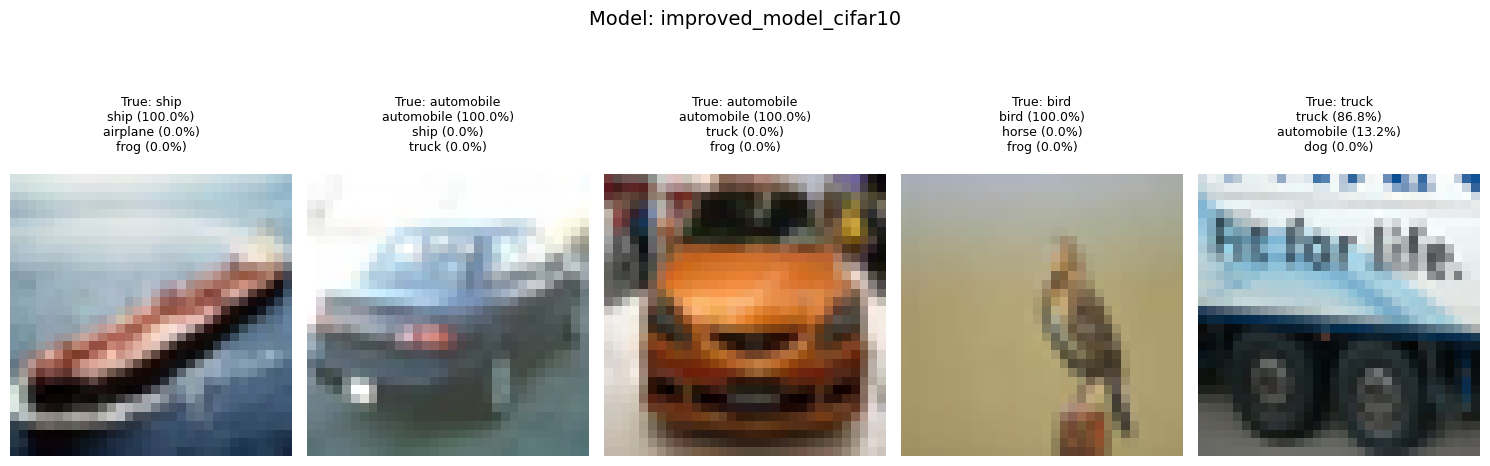


--- model3_cifar10 ---


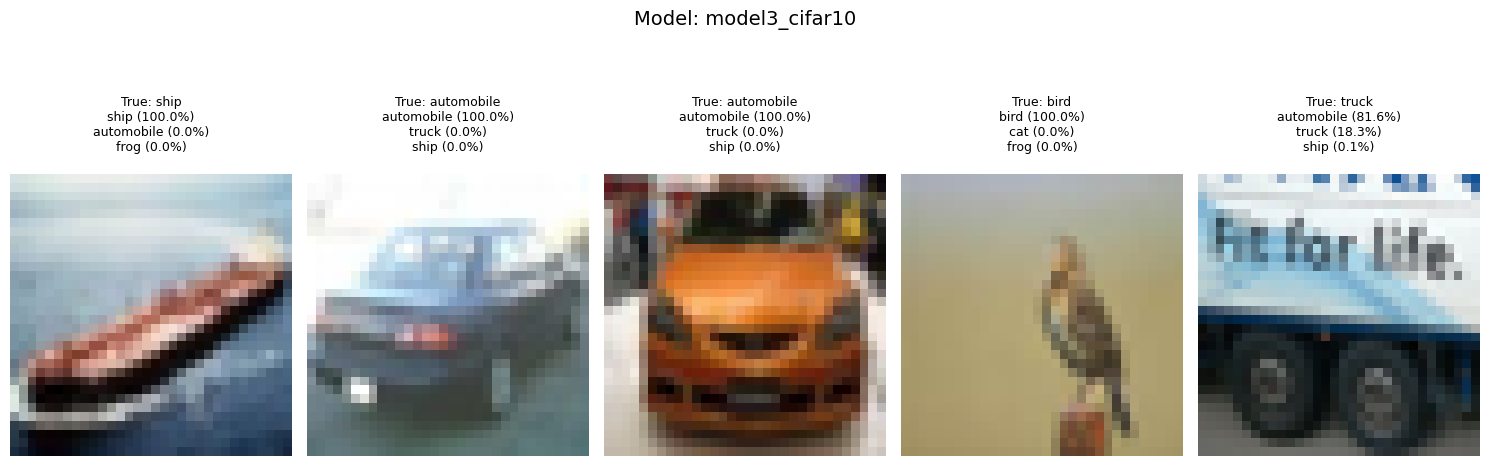


--- efficientnetb7_cifar10 ---


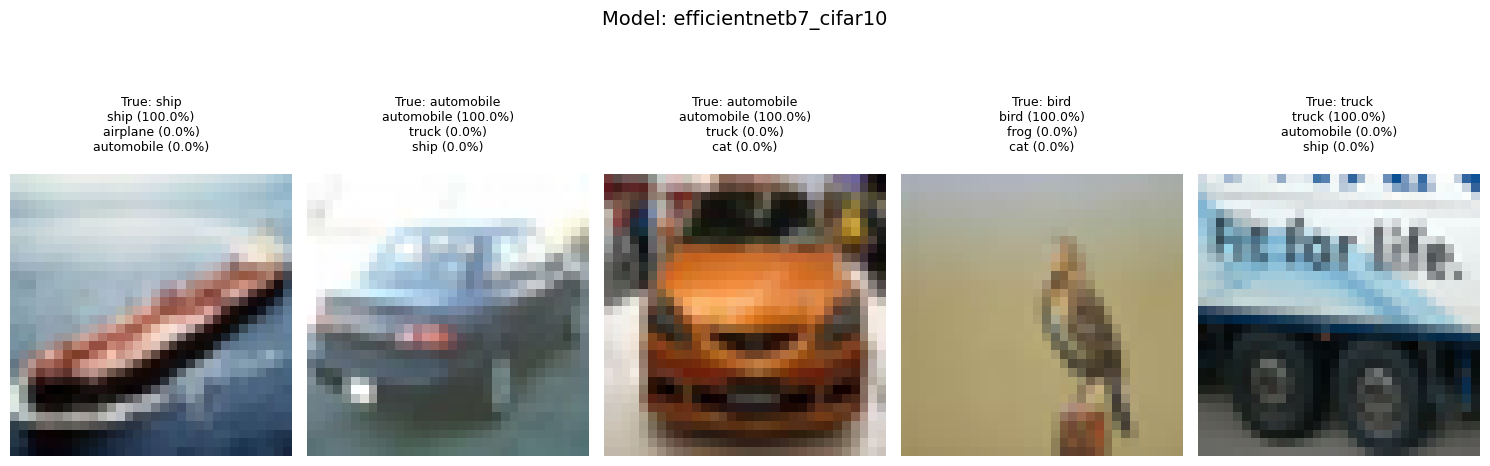


--- resnet50_cifar10 ---


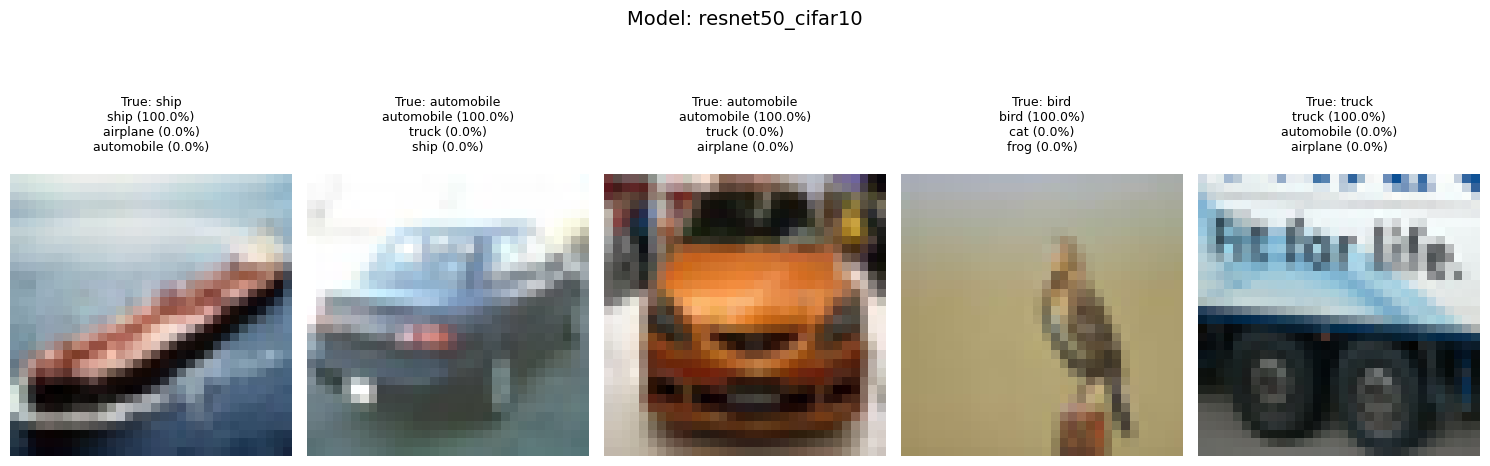

In [32]:
# CIFAR-10 test set and helpers
ds_test, ds_info = tfds.load(
    'cifar10',
    split='test',
    with_info=True,
    as_supervised=True
)
class_names = ds_info.features['label'].names

CIFAR10_MEAN = tf.constant([0.4914, 0.4822, 0.4465])
CIFAR10_STD  = tf.constant([0.2470, 0.2435, 0.2616])

def preprocess_cifar10(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - CIFAR10_MEAN) / CIFAR10_STD
    return image, label

def preprocess_efficientnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.efficientnet.preprocess_input(image)
    return image, label

def preprocess_resnet(image, label):
    image = tf.image.resize(image, [224, 224])
    image = applications.resnet.preprocess_input(image)
    return image, label

def get_random_test_images(num_samples=5):
    ds_sample = ds_test.shuffle(1000).take(num_samples)
    images, labels = [], []
    for img, label in ds_sample:
        images.append(img)
        labels.append(label)
    return images, labels

def show_predictions(model, preprocess_fn, model_name, test_images, test_labels):
    print(f"\n--- {model_name} ---")
    plt.figure(figsize=(15, 6))
    for i in range(len(test_images)):
        img = test_images[i]
        true_label = class_names[test_labels[i].numpy()]

        img_proc, _ = preprocess_fn(img, test_labels[i])
        input_tensor = tf.expand_dims(img_proc, 0)
        predictions = model.predict(input_tensor, verbose=0)[0]

        top3_idx = predictions.argsort()[-3:][::-1]
        top3_probs = predictions[top3_idx] * 100
        top3_classes = [class_names[j] for j in top3_idx]

        plt.subplot(1, len(test_images), i + 1)
        plt.imshow(tf.cast(img, tf.uint8))
        plt.axis('off')
        pred_text = f"True: {true_label}\n"
        for j in range(3):
            pred_text += f"{top3_classes[j]} ({top3_probs[j]:.1f}%)\n"
        plt.title(pred_text, fontsize=9)

    plt.suptitle(f"Model: {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Paths to saved CIFAR-10 models (relative to MODELS_DIR)
cifar10_model_paths = {
    "improved_model_cifar10":  os.path.join(MODELS_DIR, "improved_model_cifar10.keras"),
    "model3_cifar10":          os.path.join(MODELS_DIR, "model3_cifar10.keras"),
    "efficientnetb7_cifar10":  os.path.join(MODELS_DIR, "efficientnetb7_cifar10.keras"),
    "resnet50_cifar10":        os.path.join(MODELS_DIR, "resnet50_cifar10.keras"),
}

cifar10_preprocess_map = {
    "improved_model_cifar10":  preprocess_cifar10,
    "model3_cifar10":          preprocess_cifar10,
    "efficientnetb7_cifar10":  preprocess_efficientnet,
    "resnet50_cifar10":        preprocess_resnet,
}

if not USE_PRETRAINED:
    print("Warning: USE_PRETRAINED is False. "
          "This cell expects saved CIFAR-10 model files in MODELS_DIR. "
          "Make sure you either uploaded or trained and saved them before running this.")

random_images, random_labels = get_random_test_images(num_samples=5)

for name, path in cifar10_model_paths.items():
    # Check preprocess function
    if name not in cifar10_preprocess_map:
        print(f"Skipping {name} — no preprocessing function defined.")
        continue

    # Check model file exists
    if not os.path.exists(path):
        print(f"Skipping {name} — model file not found at: {path}")
        continue

    model = load_model(path)
    preprocess_fn = cifar10_preprocess_map[name]
    show_predictions(model, preprocess_fn, name, random_images, random_labels)



In [33]:
test_accuracies_10 = {}

for name, path in cifar10_model_paths.items():
    # Make sure we have a preprocessing function
    if name not in cifar10_preprocess_map:
        print(f"Skipping {name} — no preprocessing function.")
        continue

    # Make sure model file exists
    if not os.path.exists(path):
        print(f"Skipping {name} — model file not found at: {path}")
        continue

    print(f"\nEvaluating CIFAR-10 model: {name}")
    model = load_model(path)
    preprocess_fn = cifar10_preprocess_map[name]

    ds10_processed = ds_test.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds10_processed = ds10_processed.batch(128).prefetch(tf.data.AUTOTUNE)

    loss, acc = model.evaluate(ds10_processed, verbose=0)
    test_accuracies_10[name] = acc
    print(f"Test Accuracy: {acc:.4f}")

print("\n=== Final Test Accuracies (CIFAR-10) ===")
for name, acc in test_accuracies_10.items():
    print(f"{name}: {acc:.4f}")



Evaluating CIFAR-10 model: improved_model_cifar10
Test Accuracy: 0.9176

Evaluating CIFAR-10 model: model3_cifar10
Test Accuracy: 0.9182

Evaluating CIFAR-10 model: efficientnetb7_cifar10
Test Accuracy: 0.9306

Evaluating CIFAR-10 model: resnet50_cifar10
Test Accuracy: 0.9156

=== Final Test Accuracies (CIFAR-10) ===
improved_model_cifar10: 0.9176
model3_cifar10: 0.9182
efficientnetb7_cifar10: 0.9306
resnet50_cifar10: 0.9156


# Models Evaluation

---



In [34]:
model_names = [
    "model1",
    "model1_cifar100_no_overfitting",
    "model2",
    "improved_model",
    "model3",
    "efficientnetb7_cifar100",
    "resnet50_cifar100",
    "resnet50_cifar100_50epochs"
]
cifar10_model_names = [
    "improved_model_cifar10",
    "model3_cifar10",
    "efficientnetb7_cifar10",
    "resnet50_cifar10",
]


# Unified list of all history filenames for CIFAR-100 and CIFAR-10
history_files = {
    # CIFAR-100
    "model1":                         "model1_history.npy",
    "model1_cifar100_no_overfitting": "model1_cifar100_no_overfitting_history.npy",
    "model2":                         "model2_history.npy",
    "improved_model":                 "improved_model_history.npy",
    "model3":                         "model3_history.npy",
    "efficientnetb7_cifar100":        "efficientnetb7_cifar100_history.npy",
    "resnet50_cifar100":              "resnet50_cifar100_history.npy",
    "resnet50_cifar100_50epochs":     "resnet50_cifar100_50epochs_history.npy",

    # CIFAR-10
    "improved_model_cifar10":         "improved_model_cifar10_history.npy",
    "model3_cifar10":                 "model3_cifar10_history.npy",
    "efficientnetb7_cifar10":         "efficientnetb7_cifar10_history.npy",
    "resnet50_cifar10":               "resnet50_cifar10_history.npy",
}

histories = {}

print("Loading training histories...")

for name, filename in history_files.items():

    # Full path inside artifacts/histories
    path = os.path.join(HISTORIES_DIR, filename)

    if os.path.exists(path):
        try:
            hist = np.load(path, allow_pickle=True).item()
            histories[name] = hist
            print(f"Loaded: {name}")
        except Exception as e:
            print(f"Could not load history for {name} from {path}: {e}")
    else:
        print(f"History file NOT found for {name}. Expected at: {path}")

print("\nFinished loading histories.")


Loading training histories...
Loaded: model1
Loaded: model1_cifar100_no_overfitting
Loaded: model2
Loaded: improved_model
Loaded: model3
Loaded: efficientnetb7_cifar100
Loaded: resnet50_cifar100
Loaded: resnet50_cifar100_50epochs
Loaded: improved_model_cifar10
Loaded: model3_cifar10
Loaded: efficientnetb7_cifar10
Loaded: resnet50_cifar10

Finished loading histories.


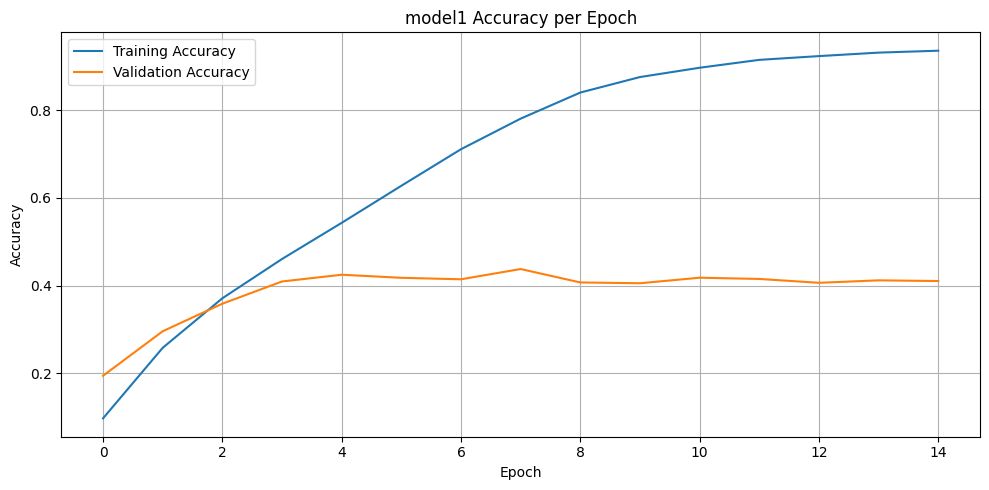

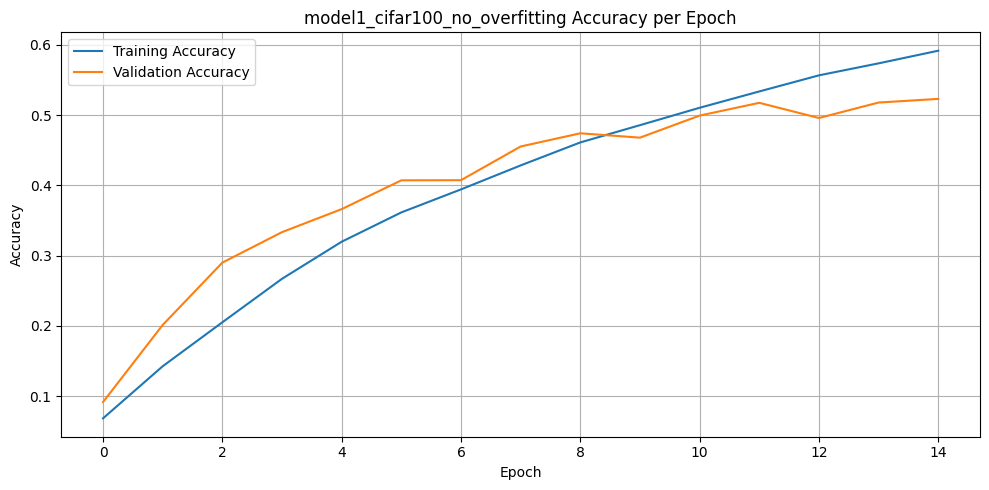

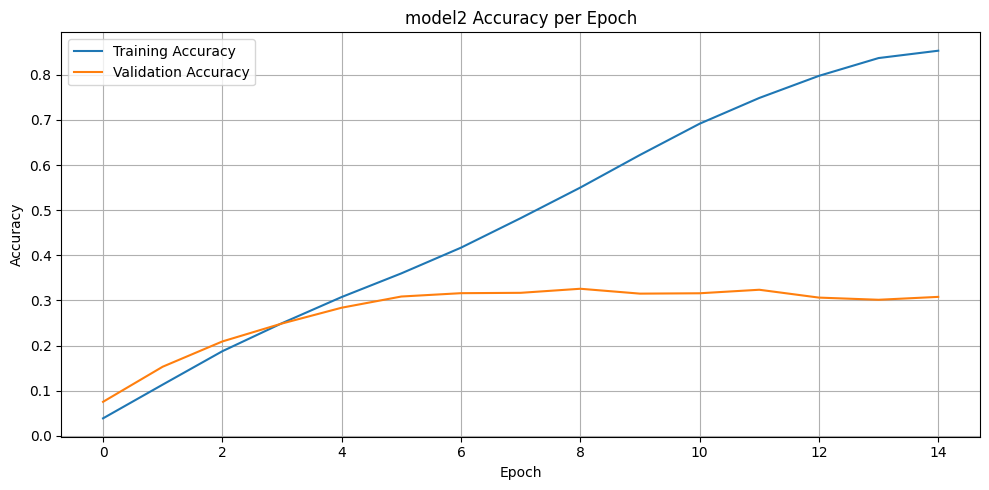

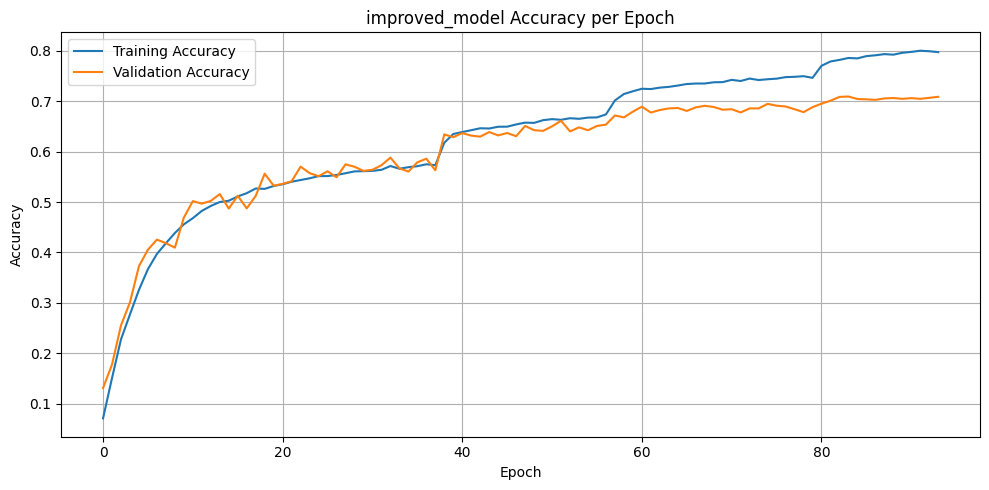

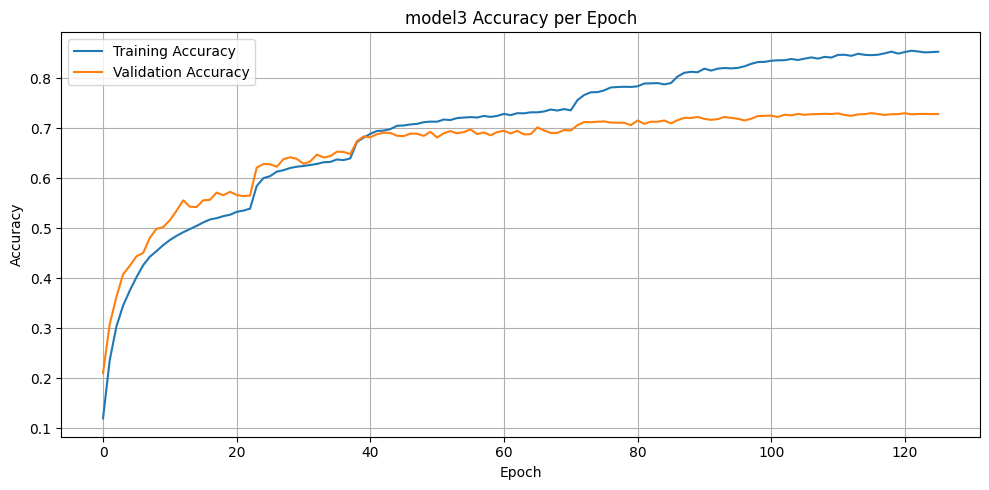

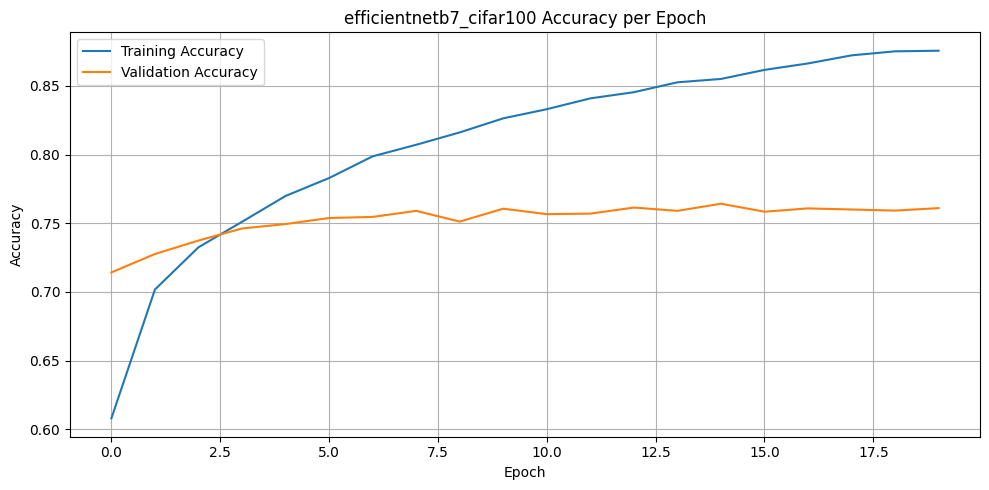

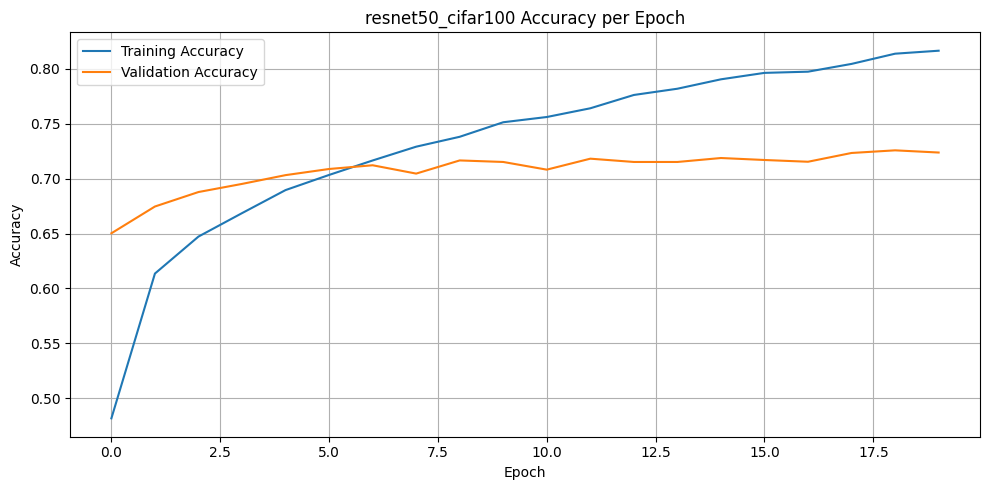

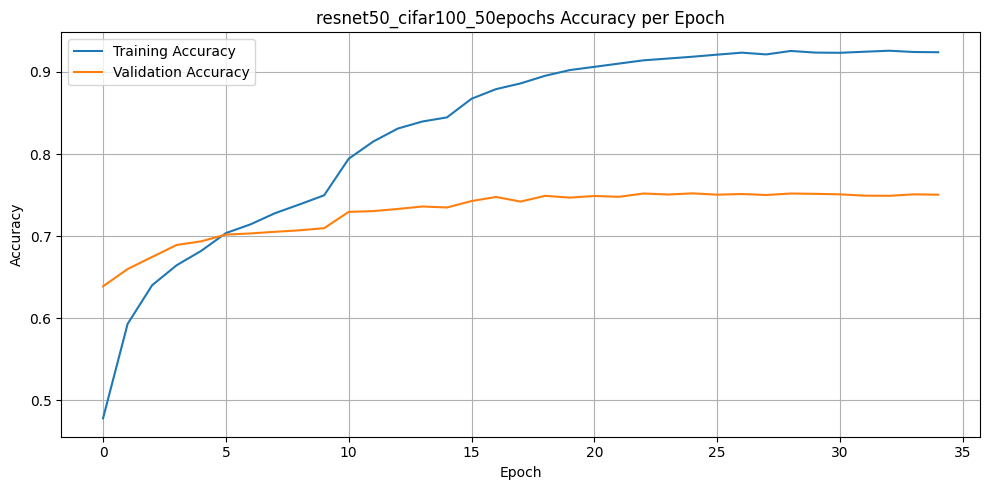

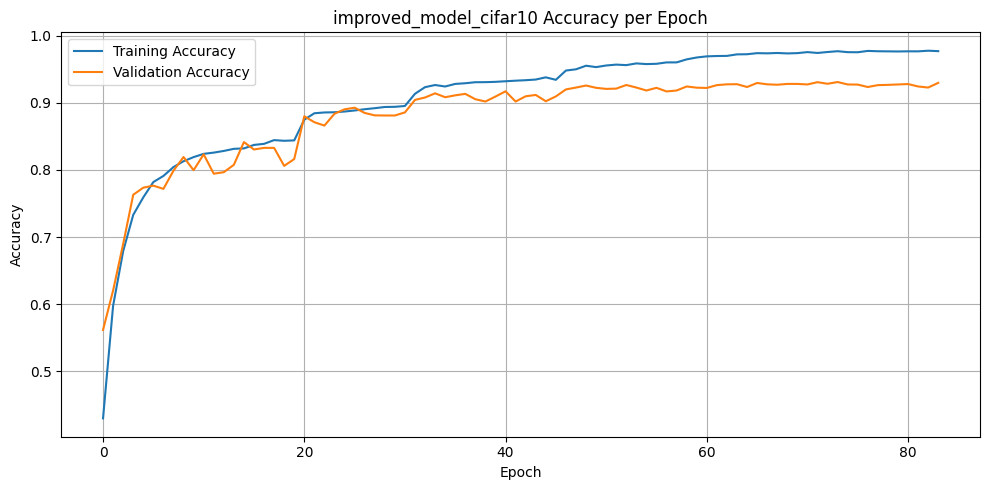

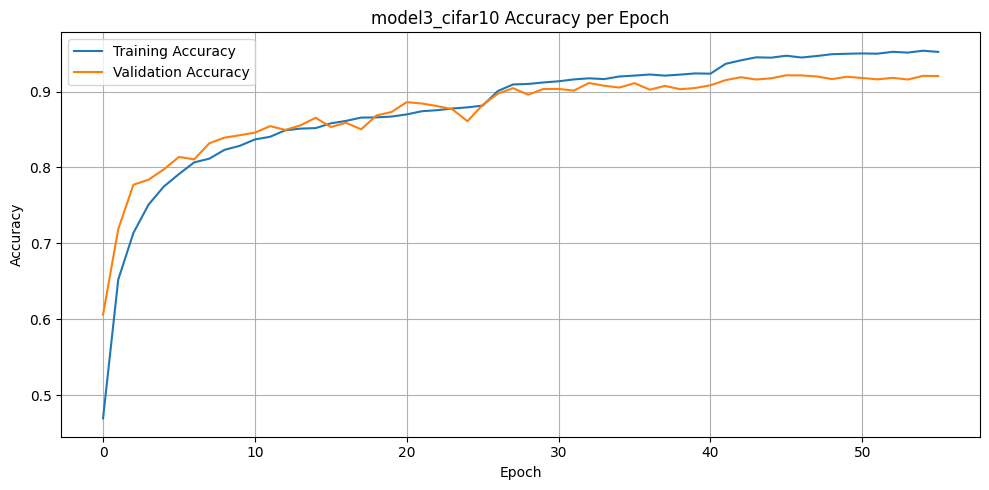

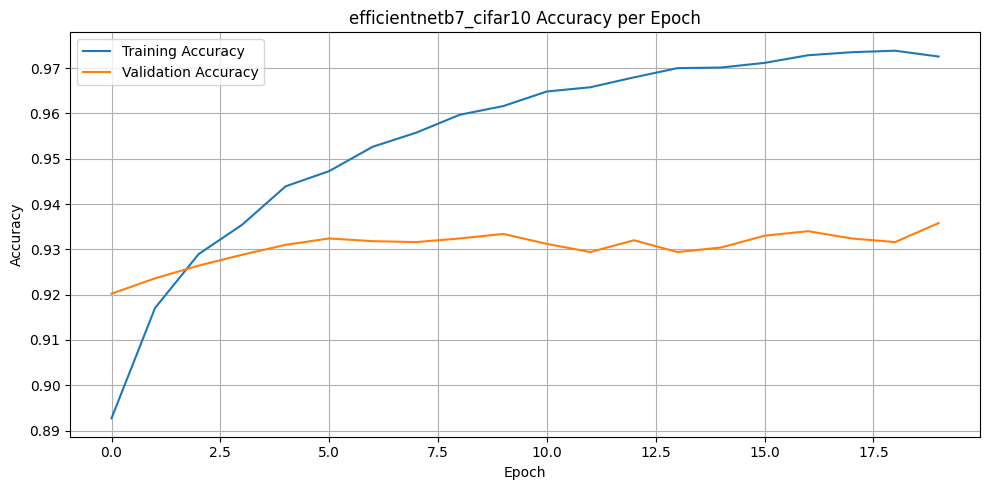

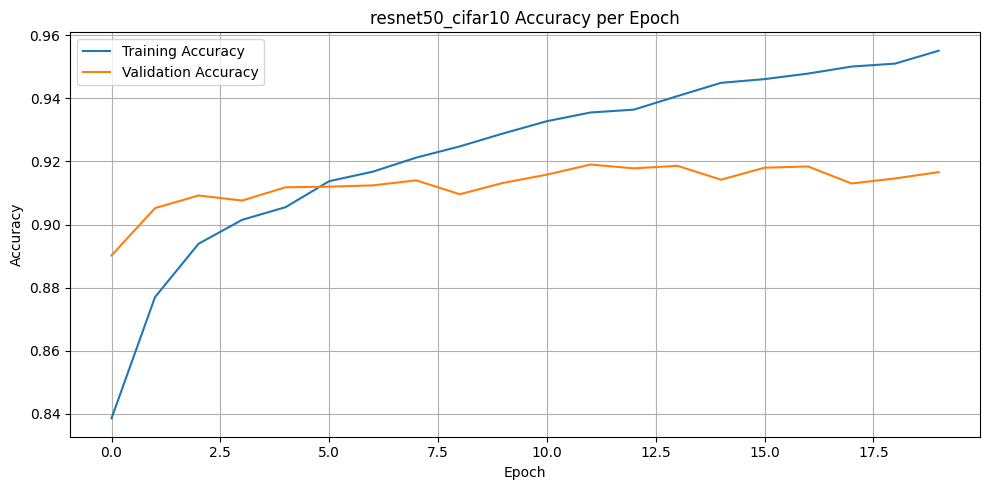

In [35]:
for name, history in histories.items():
    acc_key = None
    val_acc_key = None

    if "accuracy" in history:
        acc_key = "accuracy"
    elif "categorical_accuracy" in history:
        acc_key = "categorical_accuracy"

    if "val_accuracy" in history:
        val_acc_key = "val_accuracy"
    elif "val_categorical_accuracy" in history:
        val_acc_key = "val_categorical_accuracy"

    # Skip plotting if required keys are missing
    if acc_key is None or val_acc_key is None:
        print(f"Skipping {name} — history does not contain accuracy keys.")
        continue

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history[acc_key], label="Training Accuracy")
    plt.plot(history[val_acc_key], label="Validation Accuracy")
    plt.title(f"{name} Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


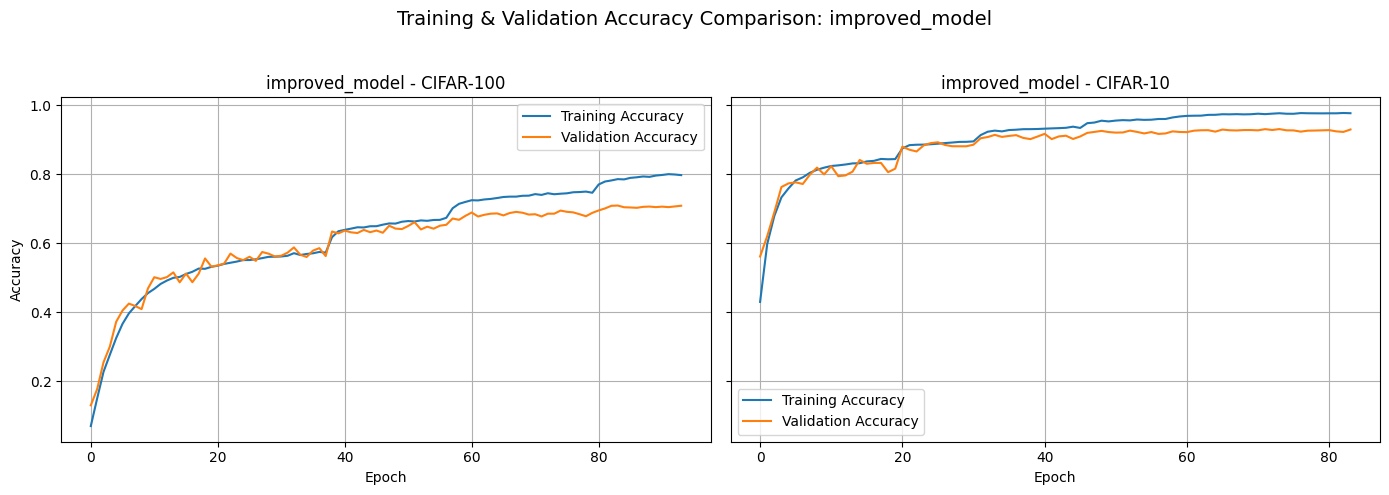

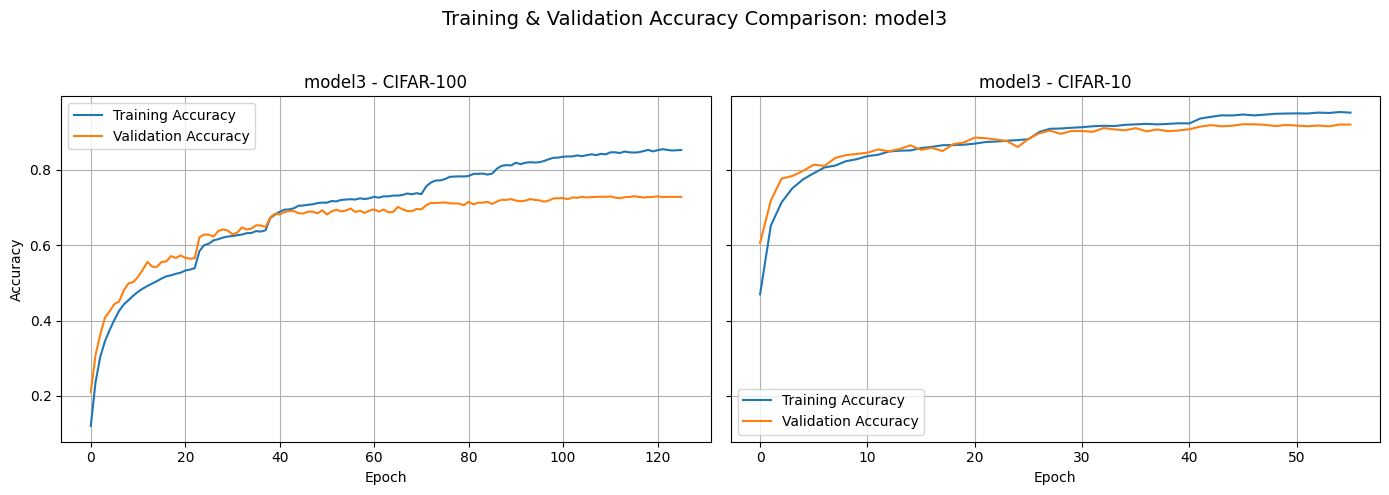

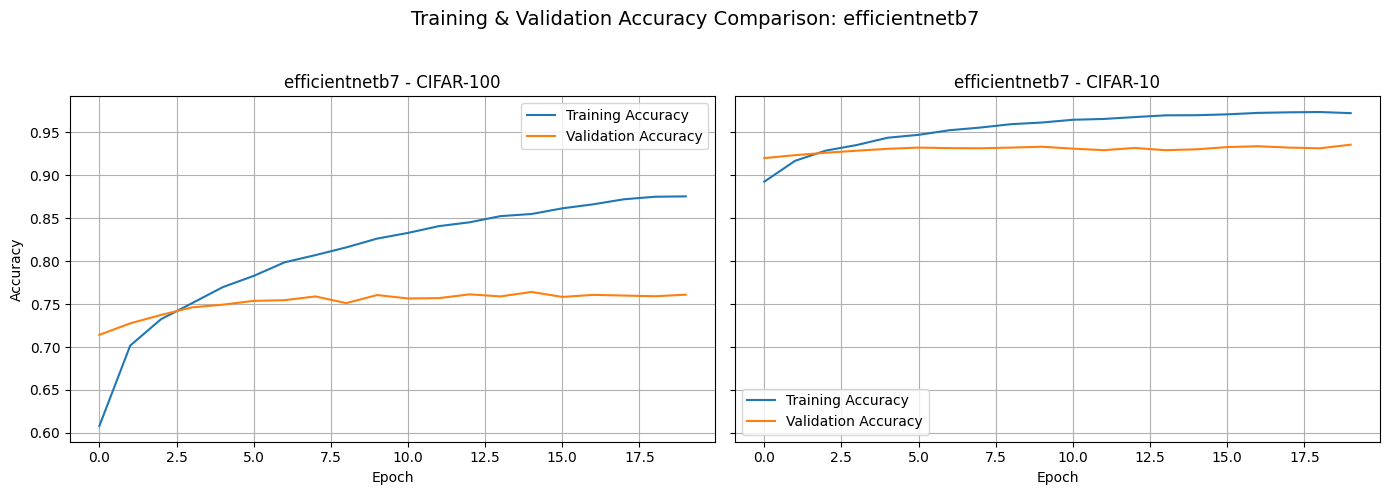

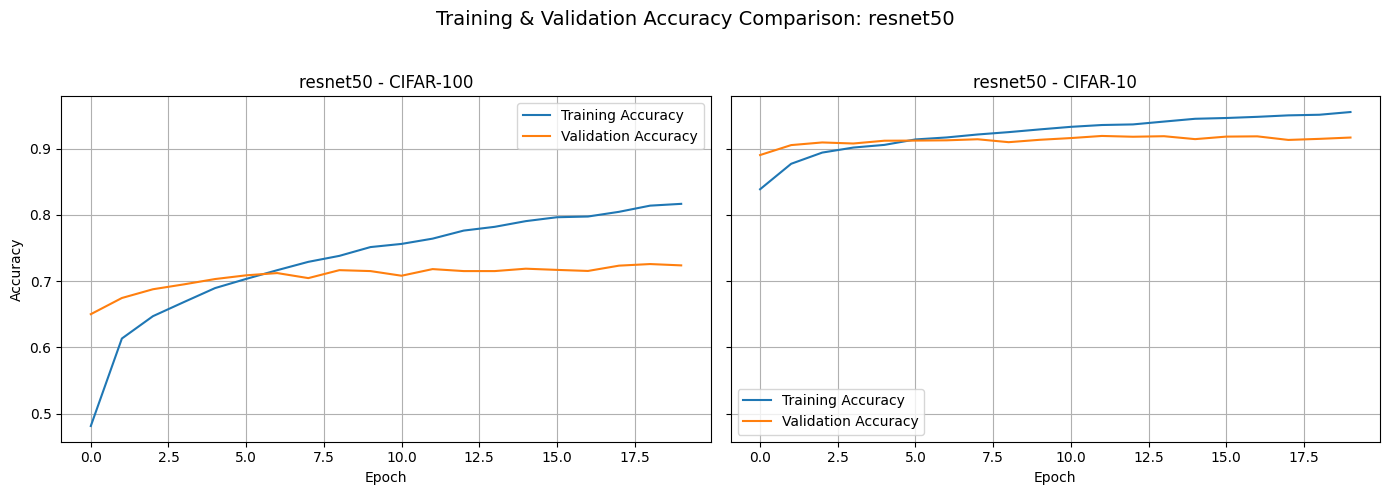

In [36]:
comparison_models = {
    "improved_model": ("improved_model", "improved_model_cifar10"),
    "model3":         ("model3", "model3_cifar10"),
    "efficientnetb7": ("efficientnetb7_cifar100", "efficientnetb7_cifar10"),
    "resnet50":       ("resnet50_cifar100", "resnet50_cifar10"),
}

for display_name, (model_c100, model_c10) in comparison_models.items():
    if model_c100 in histories and model_c10 in histories:
        hist100 = histories[model_c100]
        hist10  = histories[model_c10]

        # --- determine keys for CIFAR-100 ---
        acc_key_100 = None
        val_acc_key_100 = None

        if "accuracy" in hist100:
            acc_key_100 = "accuracy"
        elif "categorical_accuracy" in hist100:
            acc_key_100 = "categorical_accuracy"

        if "val_accuracy" in hist100:
            val_acc_key_100 = "val_accuracy"
        elif "val_categorical_accuracy" in hist100:
            val_acc_key_100 = "val_categorical_accuracy"

        # --- determine keys for CIFAR-10 ---
        acc_key_10 = None
        val_acc_key_10 = None

        if "accuracy" in hist10:
            acc_key_10 = "accuracy"
        elif "categorical_accuracy" in hist10:
            acc_key_10 = "categorical_accuracy"

        if "val_accuracy" in hist10:
            val_acc_key_10 = "val_accuracy"
        elif "val_categorical_accuracy" in hist10:
            val_acc_key_10 = "val_categorical_accuracy"

        # Skip if any required keys are missing
        if acc_key_100 is None or val_acc_key_100 is None or acc_key_10 is None or val_acc_key_10 is None:
            print(f"Skipping {display_name}: missing accuracy keys in one of the histories.")
            continue

        # --- plotting ---
        fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

        # CIFAR-100
        axs[0].plot(hist100[acc_key_100], label="Training Accuracy")
        axs[0].plot(hist100[val_acc_key_100], label="Validation Accuracy")
        axs[0].set_title(f"{display_name} - CIFAR-100")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()
        axs[0].grid(True)

        # CIFAR-10
        axs[1].plot(hist10[acc_key_10], label="Training Accuracy")
        axs[1].plot(hist10[val_acc_key_10], label="Validation Accuracy")
        axs[1].set_title(f"{display_name} - CIFAR-10")
        axs[1].set_xlabel("Epoch")
        axs[1].legend()
        axs[1].grid(True)

        plt.suptitle(f"Training & Validation Accuracy Comparison: {display_name}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    else:
        print(f"Skipping {display_name}: missing history for one of the datasets.")


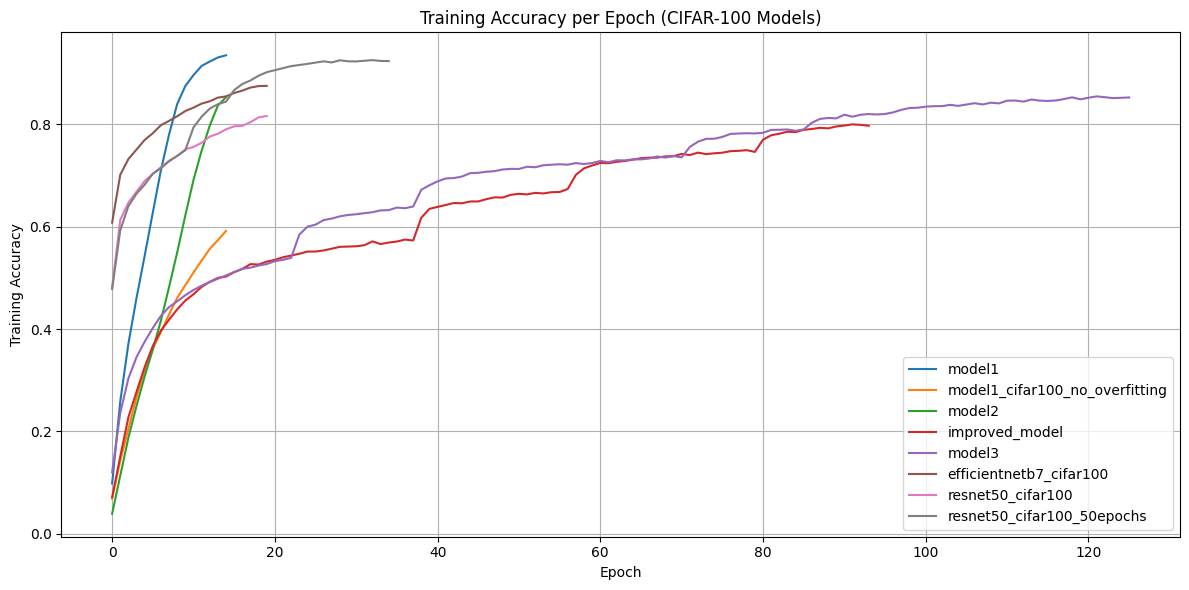

In [37]:
plt.figure(figsize=(12, 6))

for name in model_names:
    if name in histories:
        history = histories[name]

        if "accuracy" in history:
            acc_key = "accuracy"
        elif "categorical_accuracy" in history:
            acc_key = "categorical_accuracy"
        else:
            print(f"Skipping {name}: no training accuracy key found.")
            continue

        plt.plot(history[acc_key], label=name)

    else:
        print(f"History for {name} not found.")

plt.title("Training Accuracy per Epoch (CIFAR-100 Models)")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


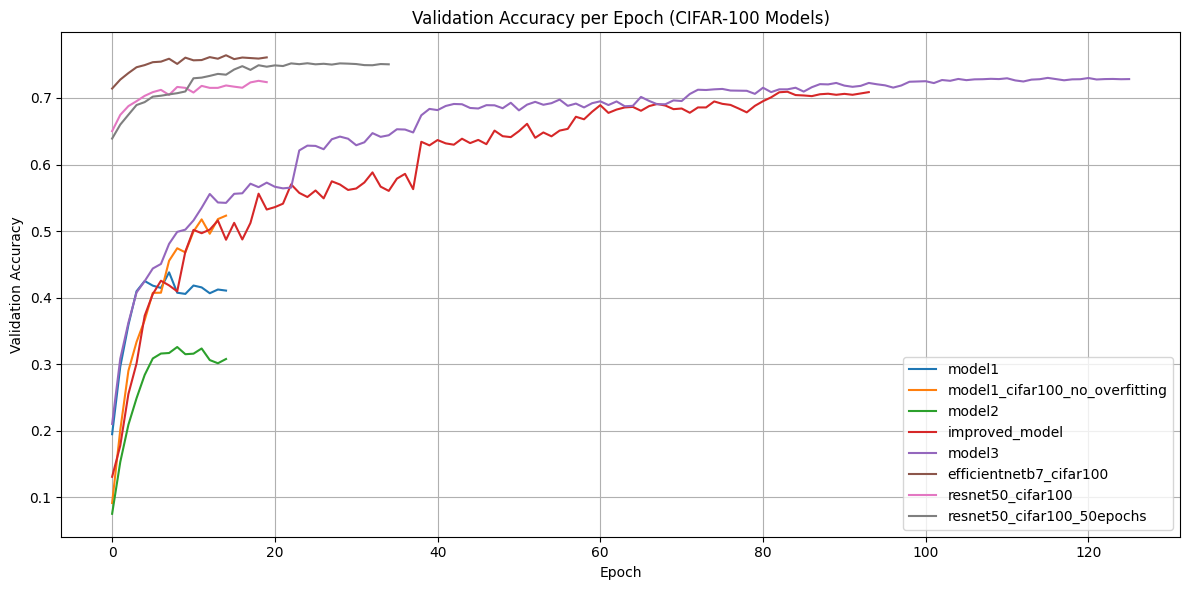

In [38]:
plt.figure(figsize=(12, 6))

for name in model_names:
    if name in histories:
        history = histories[name]


        if "val_accuracy" in history:
            val_acc_key = "val_accuracy"
        elif "val_categorical_accuracy" in history:
            val_acc_key = "val_categorical_accuracy"
        else:
            print(f"Skipping {name}: no validation accuracy key found.")
            continue

        plt.plot(history[val_acc_key], label=name)

    else:
        print(f"History for {name} not found.")

plt.title("Validation Accuracy per Epoch (CIFAR-100 Models)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



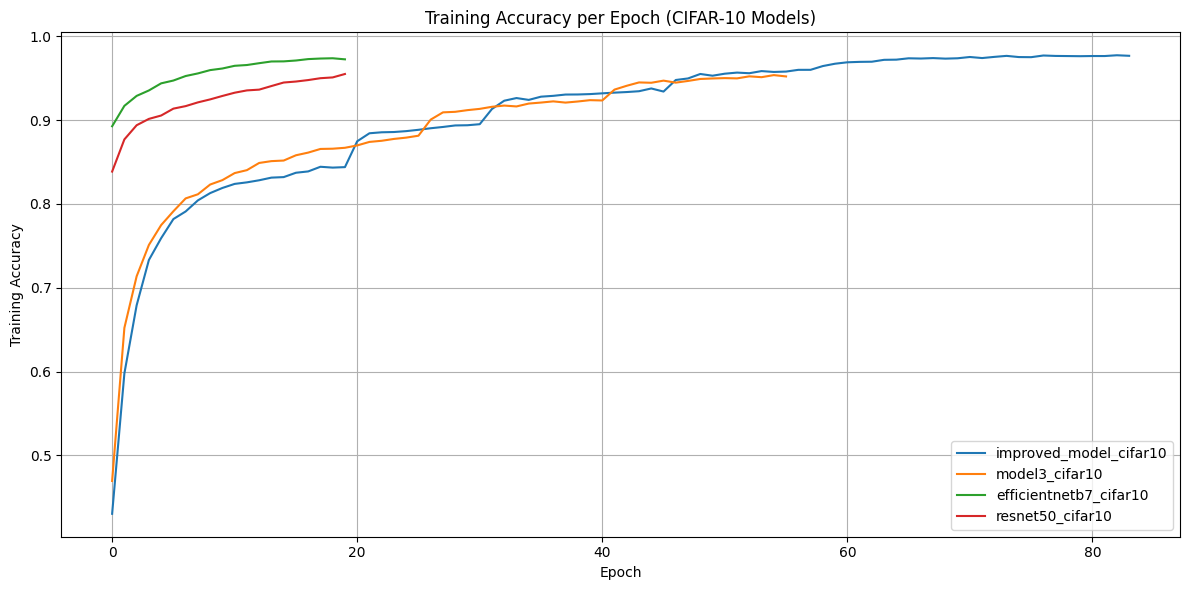

In [39]:


plt.figure(figsize=(12, 6))

for name in cifar10_model_names:
    if name in histories:
        history = histories[name]

        if "accuracy" in history:
            acc_key = "accuracy"
        elif "categorical_accuracy" in history:
            acc_key = "categorical_accuracy"
        else:
            print(f"Skipping {name}: no training accuracy key found.")
            continue

        plt.plot(history[acc_key], label=name)

    else:
        print(f"History for {name} not found.")

plt.title("Training Accuracy per Epoch (CIFAR-10 Models)")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



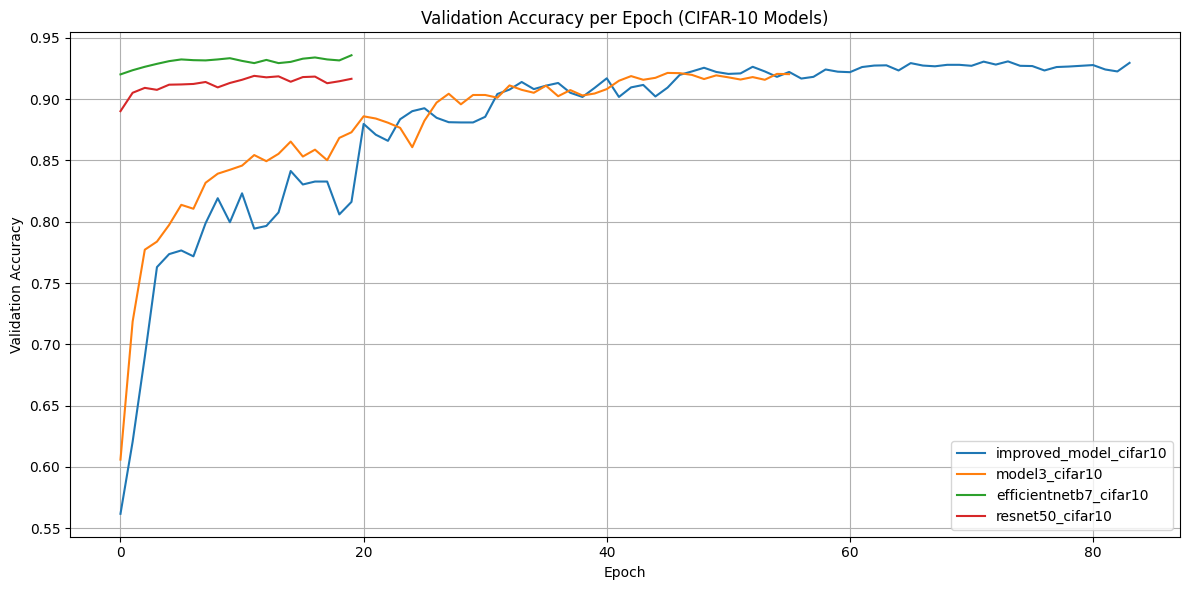

In [40]:

plt.figure(figsize=(12, 6))

for name in cifar10_model_names:
    if name in histories:
        history = histories[name]

        # Determine correct validation accuracy key
        if "val_accuracy" in history:
            val_acc_key = "val_accuracy"
        elif "val_categorical_accuracy" in history:
            val_acc_key = "val_categorical_accuracy"
        else:
            print(f"Skipping {name}: no validation accuracy key found.")
            continue

        plt.plot(history[val_acc_key], label=name)

    else:
        print(f"History for {name} not found.")

plt.title("Validation Accuracy per Epoch (CIFAR-10 Models)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



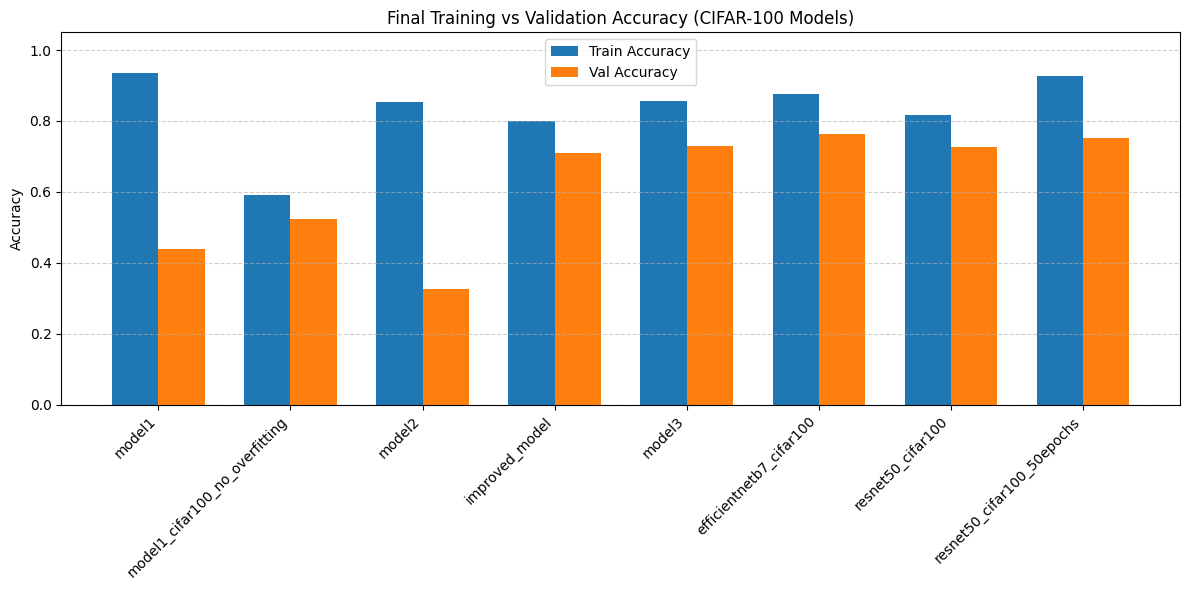

In [41]:
train_accs = []
val_accs = []
valid_names = []

for name in model_names:
    if name in histories:
        history = histories[name]

        # Determine training accuracy key
        if "accuracy" in history:
            acc_key = "accuracy"
        elif "categorical_accuracy" in history:
            acc_key = "categorical_accuracy"
        else:
            print(f"Skipping {name}: no training accuracy key found.")
            continue

        # Determine validation accuracy key
        if "val_accuracy" in history:
            val_acc_key = "val_accuracy"
        elif "val_categorical_accuracy" in history:
            val_acc_key = "val_categorical_accuracy"
        else:
            print(f"Skipping {name}: no validation accuracy key found.")
            continue

        try:
            train_accs.append(max(history[acc_key]))
            val_accs.append(max(history[val_acc_key]))
            valid_names.append(name)
        except Exception as e:
            print(f"Could not compute final accuracy for {name}: {e}")
    else:
        print(f"History not found for {name}")

x = np.arange(len(valid_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, train_accs, width, label='Train Accuracy')
plt.bar(x + width / 2, val_accs, width, label='Val Accuracy')
plt.xticks(x, valid_names, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Final Training vs Validation Accuracy (CIFAR-100 Models)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


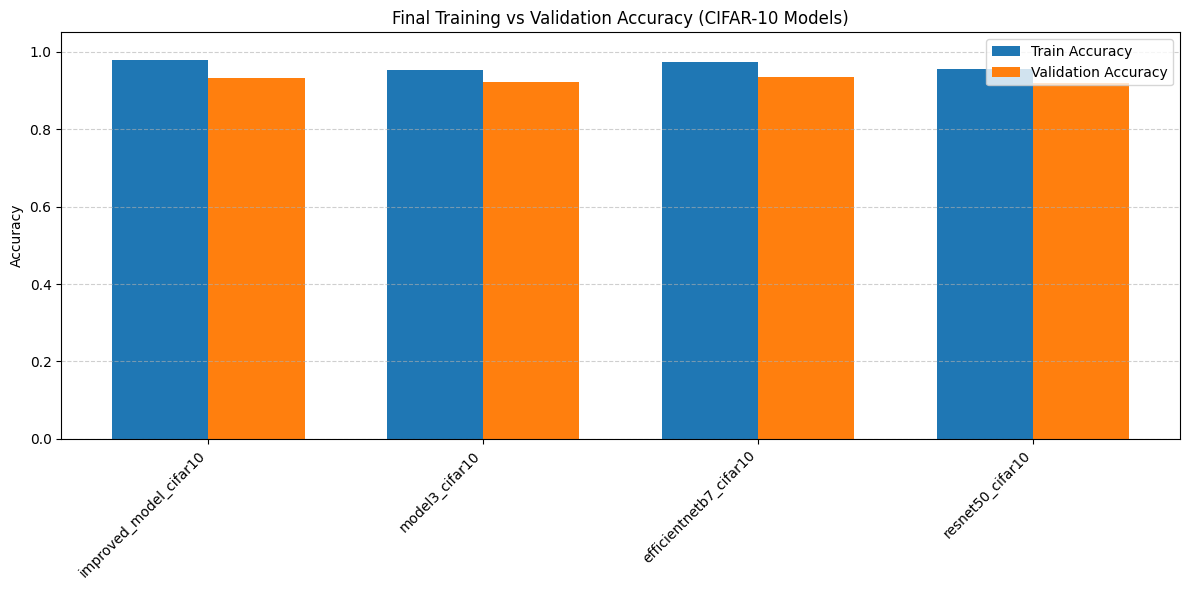

In [42]:

train_accs = []
val_accs = []
valid_names = []

for name in cifar10_model_names:
    if name in histories:
        history = histories[name]


        if "accuracy" in history:
            acc_key = "accuracy"
        elif "categorical_accuracy" in history:
            acc_key = "categorical_accuracy"
        else:
            print(f"Skipping {name}: no training accuracy key found.")
            continue


        if "val_accuracy" in history:
            val_acc_key = "val_accuracy"
        elif "val_categorical_accuracy" in history:
            val_acc_key = "val_categorical_accuracy"
        else:
            print(f"Skipping {name}: no validation accuracy key found.")
            continue

        try:
            train_accs.append(max(history[acc_key]))
            val_accs.append(max(history[val_acc_key]))
            valid_names.append(name)
        except Exception as e:
            print(f"Could not compute final accuracy for {name}: {e}")

    else:
        print(f"History not found for {name}")

x = np.arange(len(valid_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, train_accs, width, label='Train Accuracy')
plt.bar(x + width / 2, val_accs, width, label='Validation Accuracy')
plt.xticks(x, valid_names, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Final Training vs Validation Accuracy (CIFAR-10 Models)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


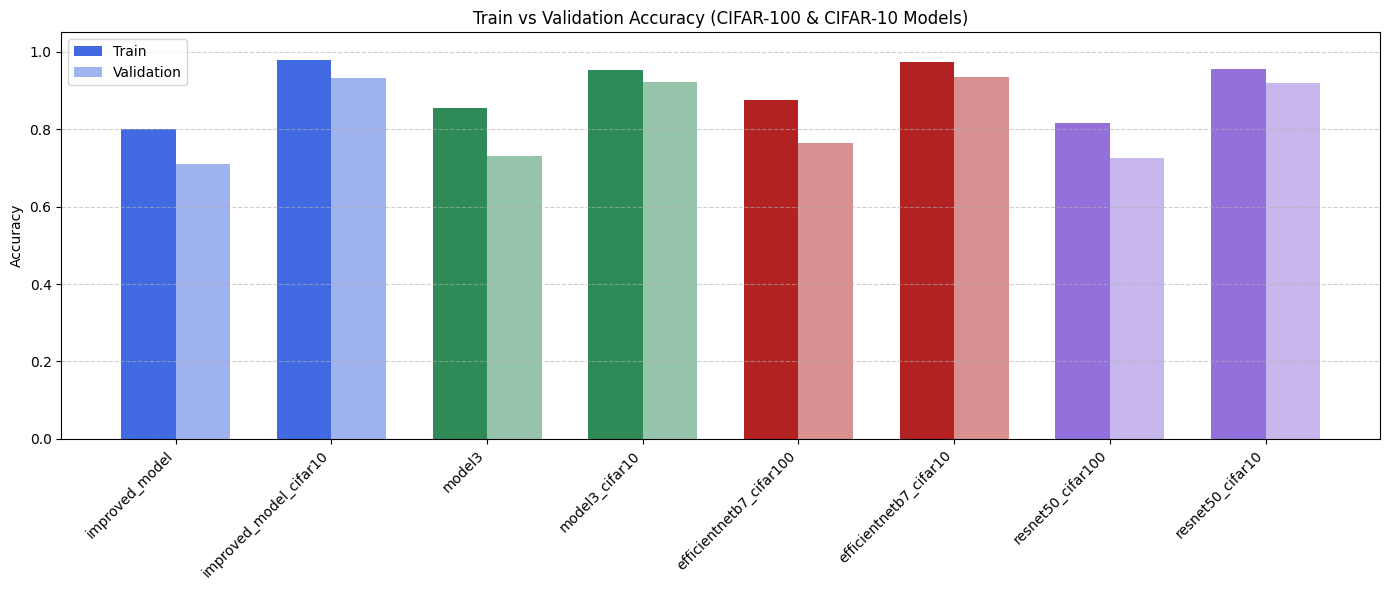

In [43]:
from matplotlib.colors import to_rgba

model_colors = {
    "improved_model": "royalblue",
    "model3":         "seagreen",
    "efficientnetb7": "firebrick",
    "resnet50":       "mediumpurple",
}

labels = []
train_accs = []
val_accs = []
train_colors = []
val_colors = []

for model_key, (model100, model10) in comparison_models.items():
    base_color = model_colors.get(model_key, "gray")  # default color if not found

    for model in [model100, model10]:
        if model in histories:
            hist = histories[model]

            # Determine training accuracy key
            if "accuracy" in hist:
                acc_key = "accuracy"
            elif "categorical_accuracy" in hist:
                acc_key = "categorical_accuracy"
            else:
                print(f"Skipping {model}: no training accuracy key found.")
                continue

            # Determine validation accuracy key
            if "val_accuracy" in hist:
                val_acc_key = "val_accuracy"
            elif "val_categorical_accuracy" in hist:
                val_acc_key = "val_categorical_accuracy"
            else:
                print(f"Skipping {model}: no validation accuracy key found.")
                continue

            try:
                train_accs.append(max(hist[acc_key]))
                val_accs.append(max(hist[val_acc_key]))
                labels.append(model)

                train_colors.append(base_color)
                lighter_rgba = to_rgba(base_color, alpha=0.5)
                val_colors.append(lighter_rgba)
            except Exception as e:
                print(f"Could not compute accuracy for {model}: {e}")
        else:
            print(f"Missing history for {model}")

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(14, 6))

for i in range(len(labels)):
    plt.bar(
        x[i] - width / 2,
        train_accs[i],
        width,
        color=train_colors[i],
        label='Train' if i == 0 else "",
    )
    plt.bar(
        x[i] + width / 2,
        val_accs[i],
        width,
        color=val_colors[i],
        label='Validation' if i == 0 else "",
    )

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (CIFAR-100 & CIFAR-10 Models)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Evaluating normalized confusion matrix for model1...


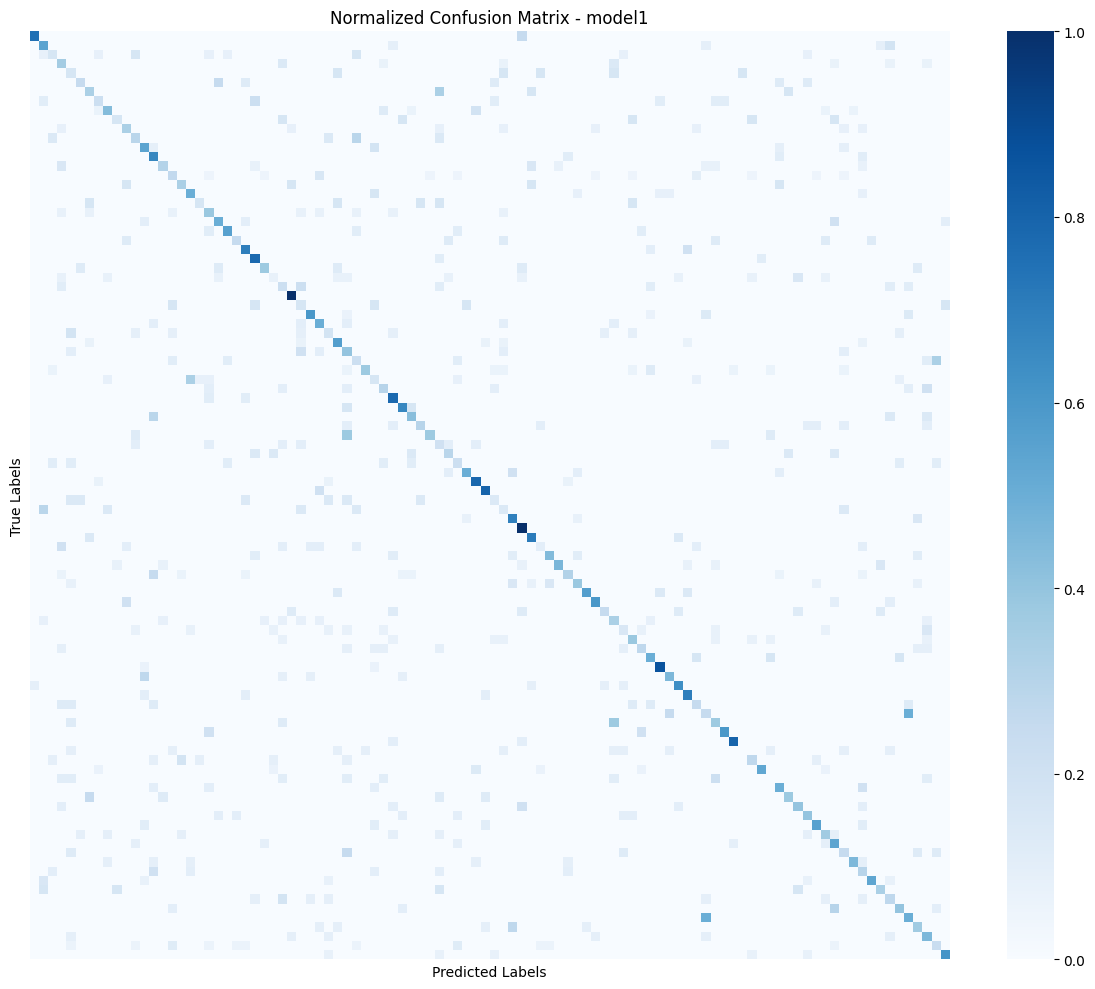


Evaluating normalized confusion matrix for model1_no_overfitting...


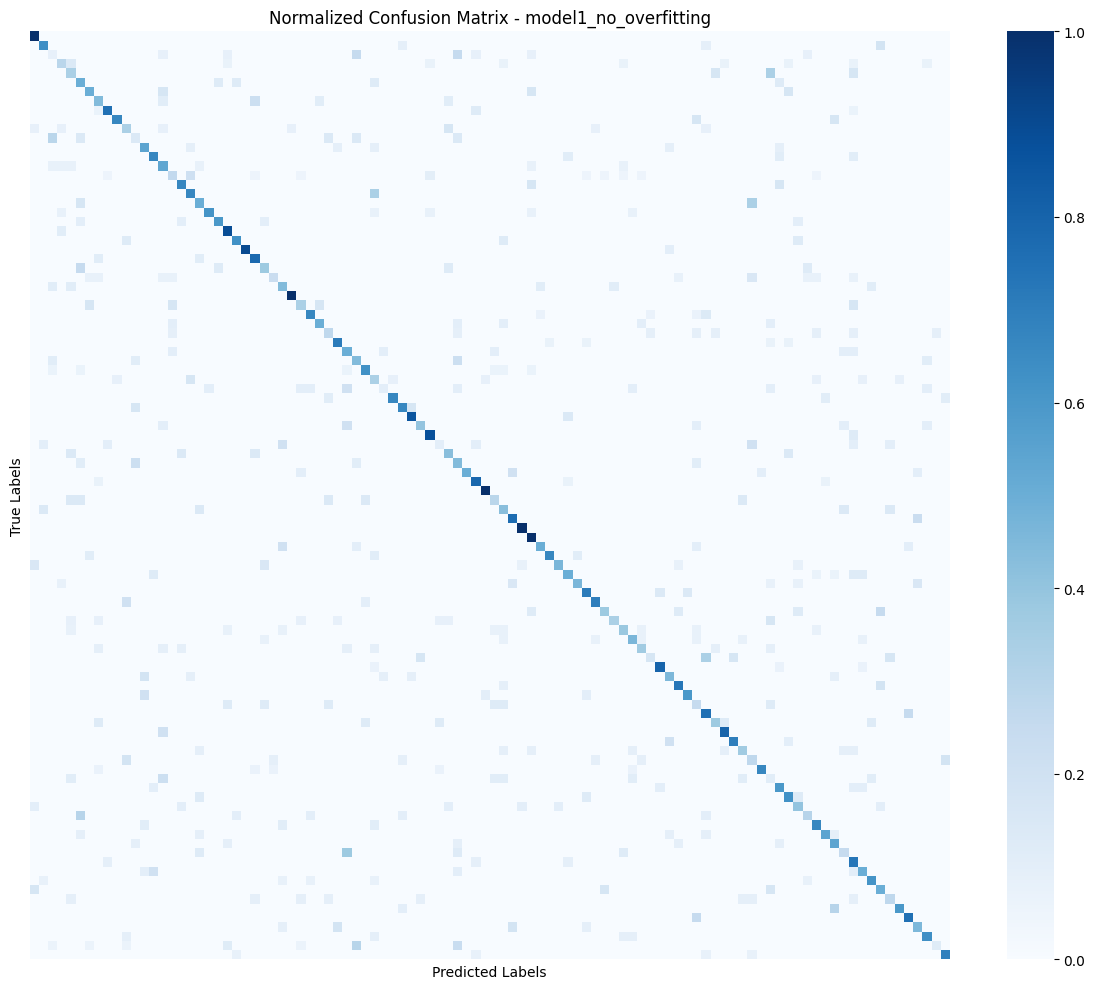


Evaluating normalized confusion matrix for model2...


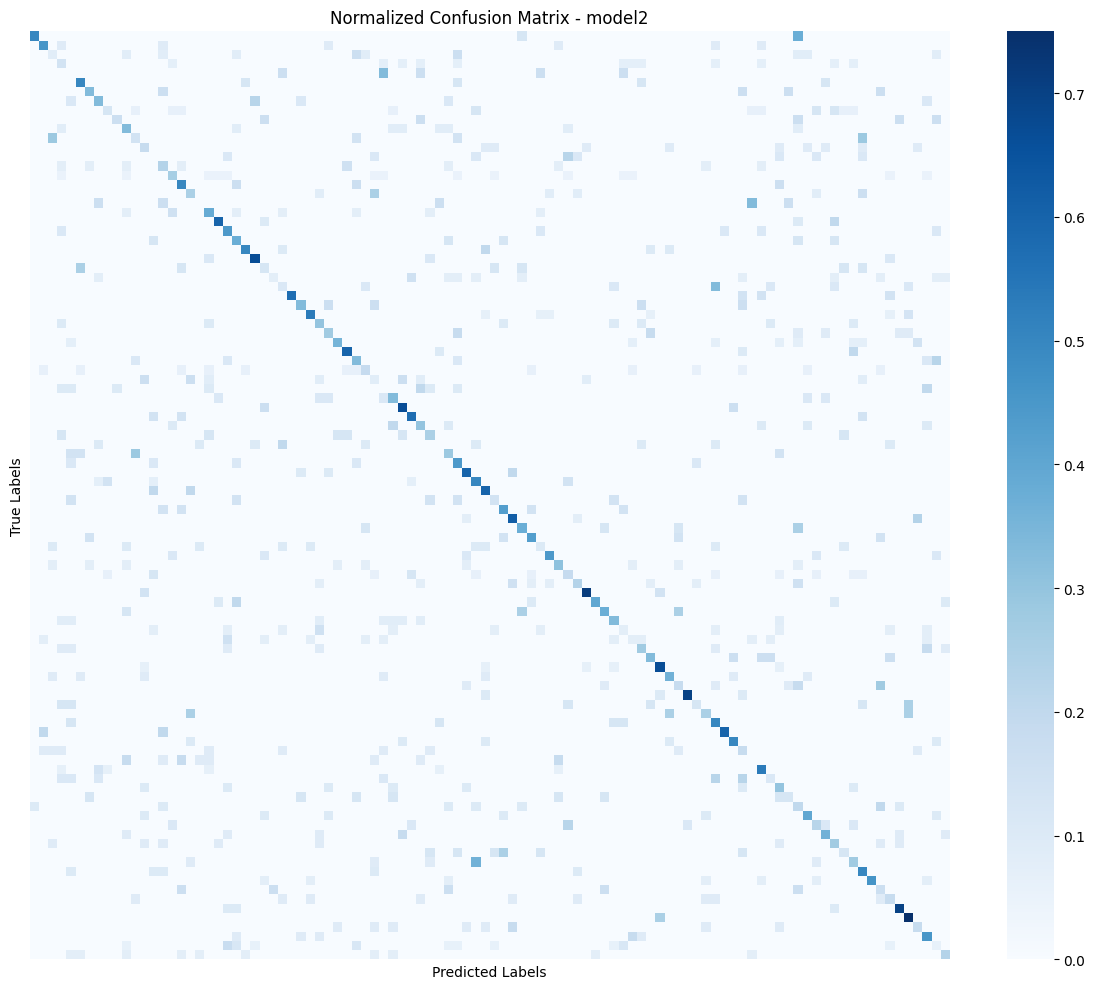


Evaluating normalized confusion matrix for improved_model...


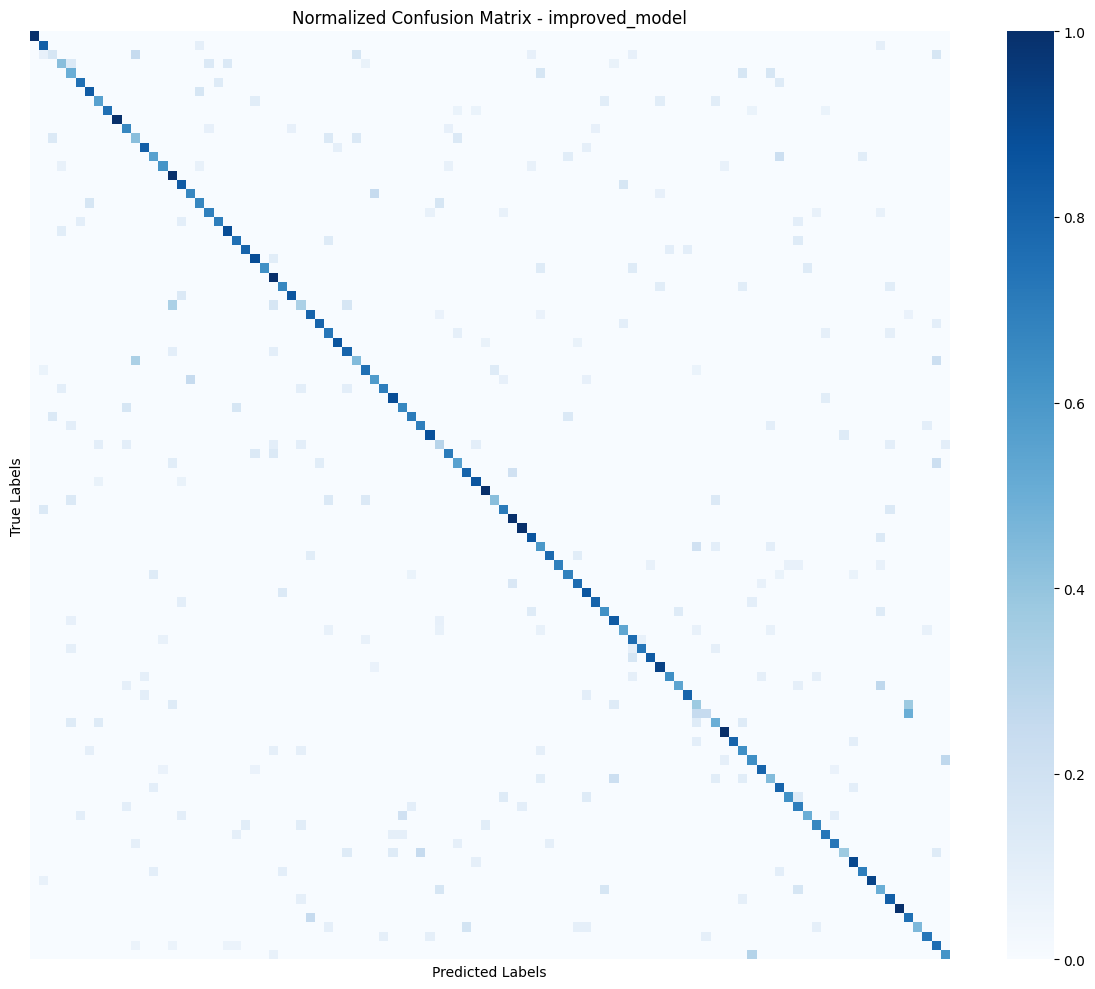


Evaluating normalized confusion matrix for model3...


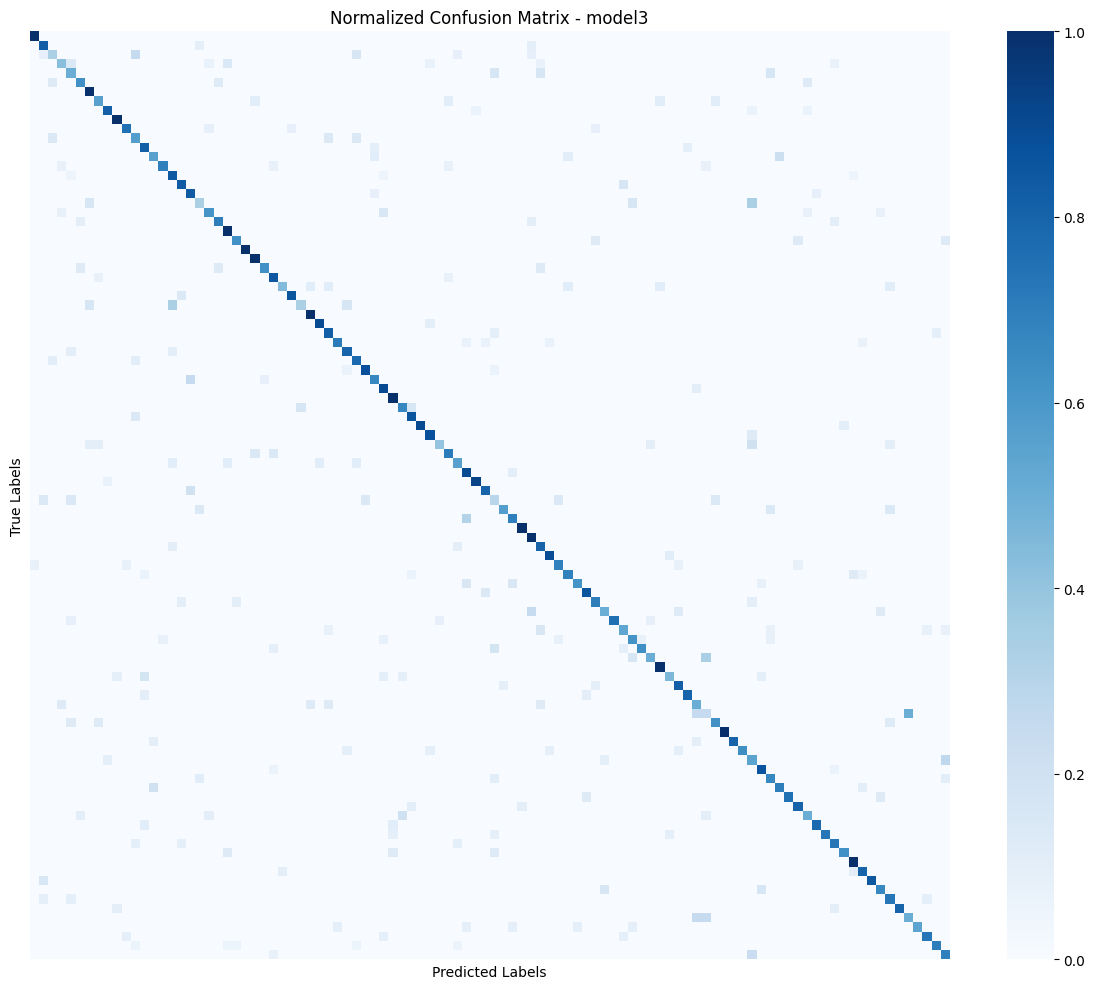


Evaluating normalized confusion matrix for efficientnetb7...


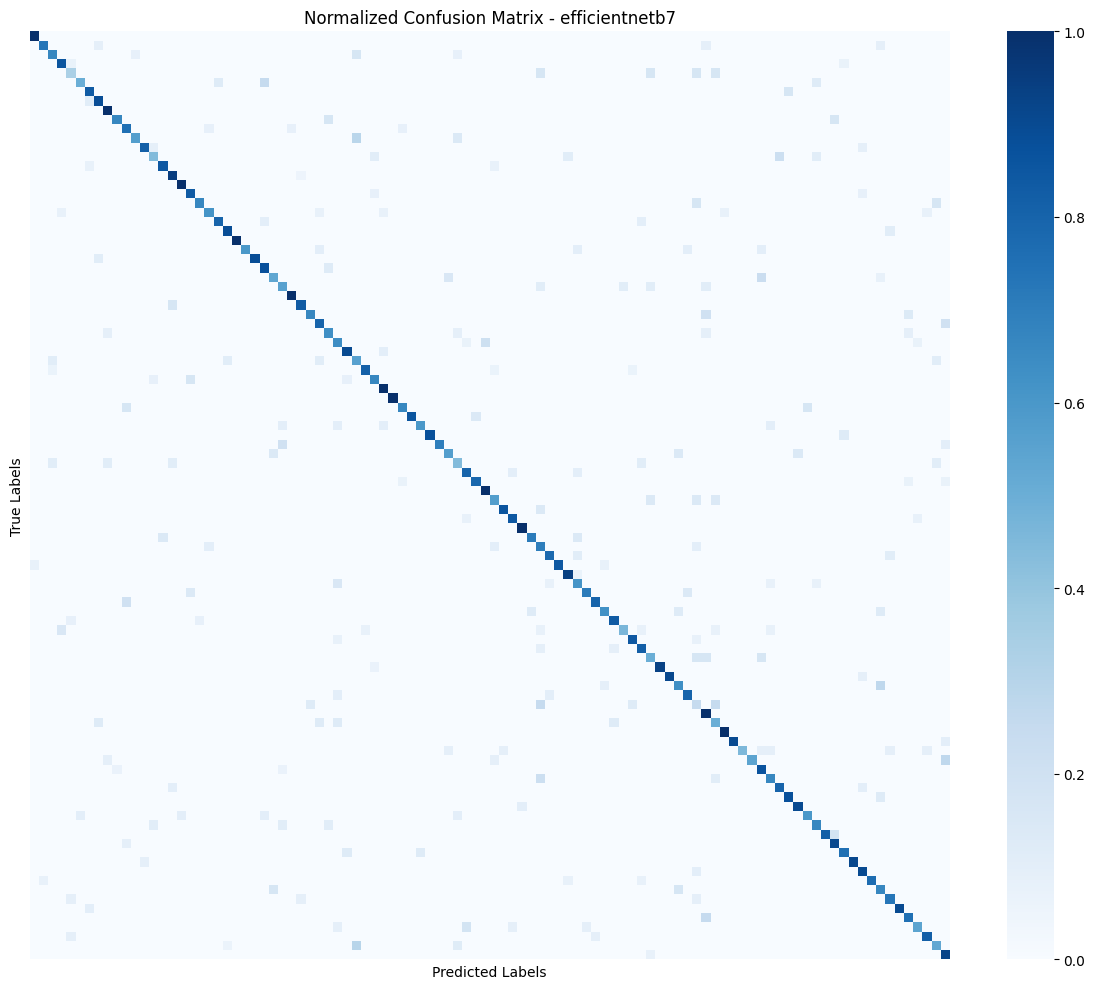


Evaluating normalized confusion matrix for resnet50...


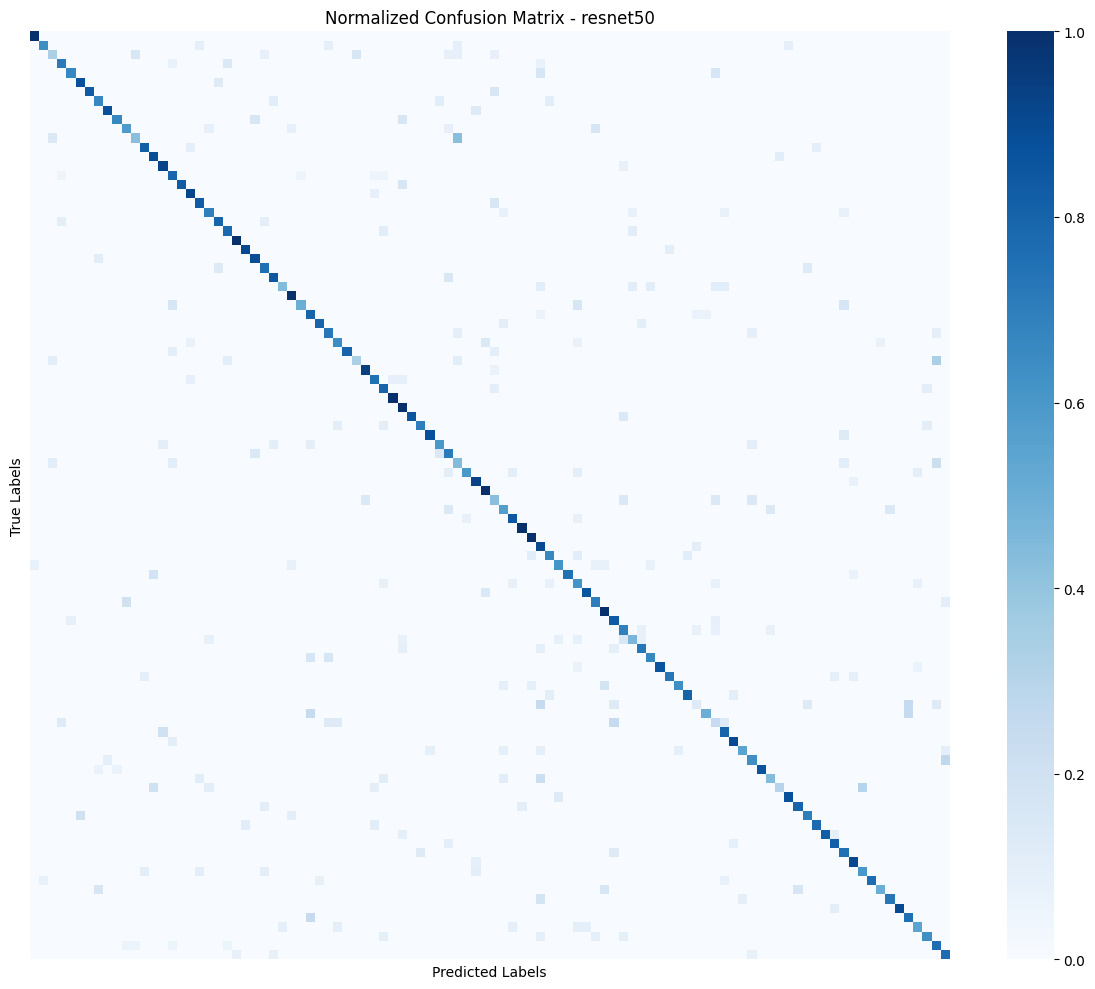


Evaluating normalized confusion matrix for resnet50_50epochs...


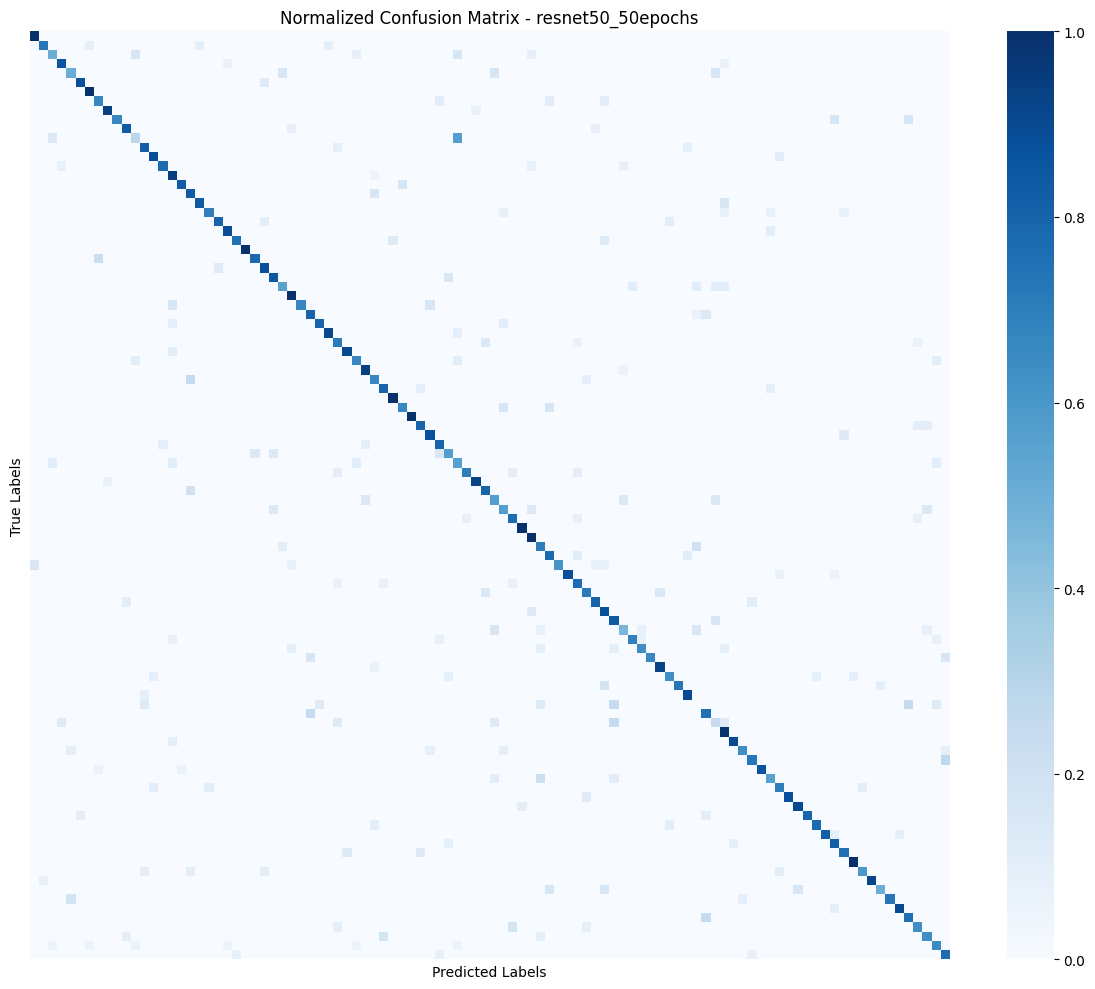

In [44]:
# CIFAR-100 test set subset for confusion matrices
ds_test, ds_info = tfds.load(
    'cifar100',
    split='test',
    with_info=True,
    as_supervised=True
)
class_names = ds_info.features['label'].names

# Take a subset of the test set for faster confusion matrix computation
test_subset = ds_test.take(1000)
x_test_raw, y_test = [], []

for img, label in test_subset:
    x_test_raw.append(img)
    y_test.append(label.numpy())

x_test_raw = tf.stack(x_test_raw)
y_test = np.array(y_test)

def get_model_predictions(model, preprocess_fn, x_data):
    """
    Apply the given preprocess function to a batch of images and
    return the predicted class indices.
    """
    processed_imgs = [preprocess_fn(img, 0)[0] for img in x_data]
    x_proc = tf.stack(processed_imgs)
    preds = model.predict(x_proc, verbose=0)
    return np.argmax(preds, axis=1)

for name, path in model_paths.items():
    # Ensure we have a preprocessing function
    if name not in preprocess_map:
        print(f"Skipping {name}: no preprocessing function defined.")
        continue

    # Ensure the model file exists
    if not os.path.exists(path):
        print(f"Skipping {name}: model file not found at: {path}")
        continue

    print(f"\nEvaluating normalized confusion matrix for {name}...")
    model = load_model(path)
    preprocess_fn = preprocess_map[name]

    y_pred = get_model_predictions(model, preprocess_fn, x_test_raw)

    cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
    cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, cmap="Blues", xticklabels=False, yticklabels=False)
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()




Evaluating normalized confusion matrix for improved_model_cifar10...


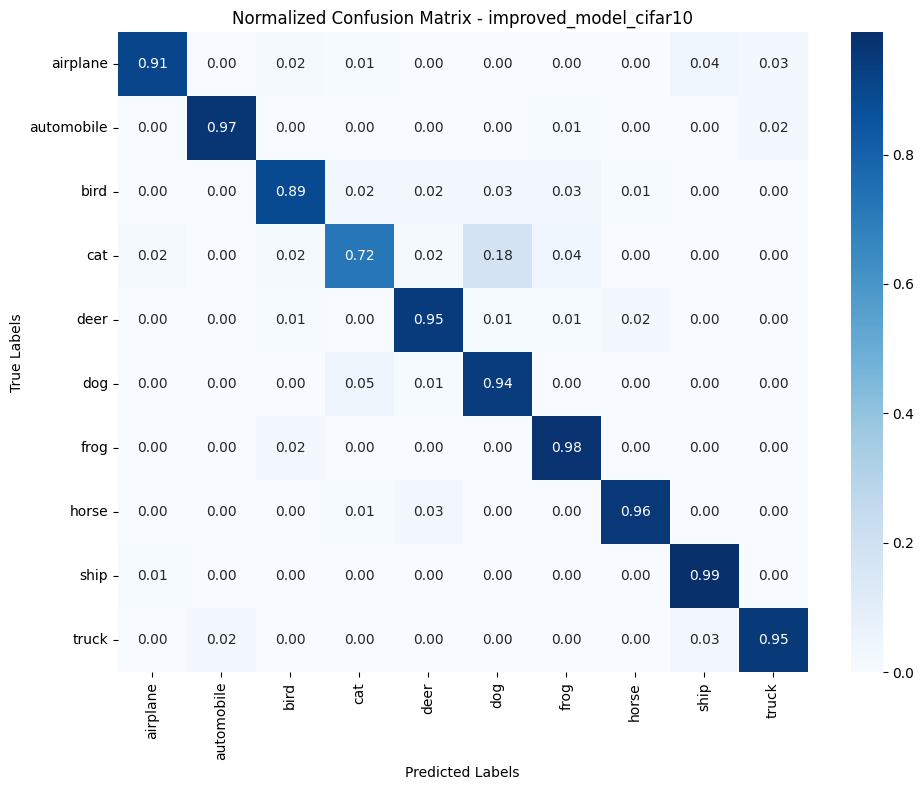


Evaluating normalized confusion matrix for model3_cifar10...


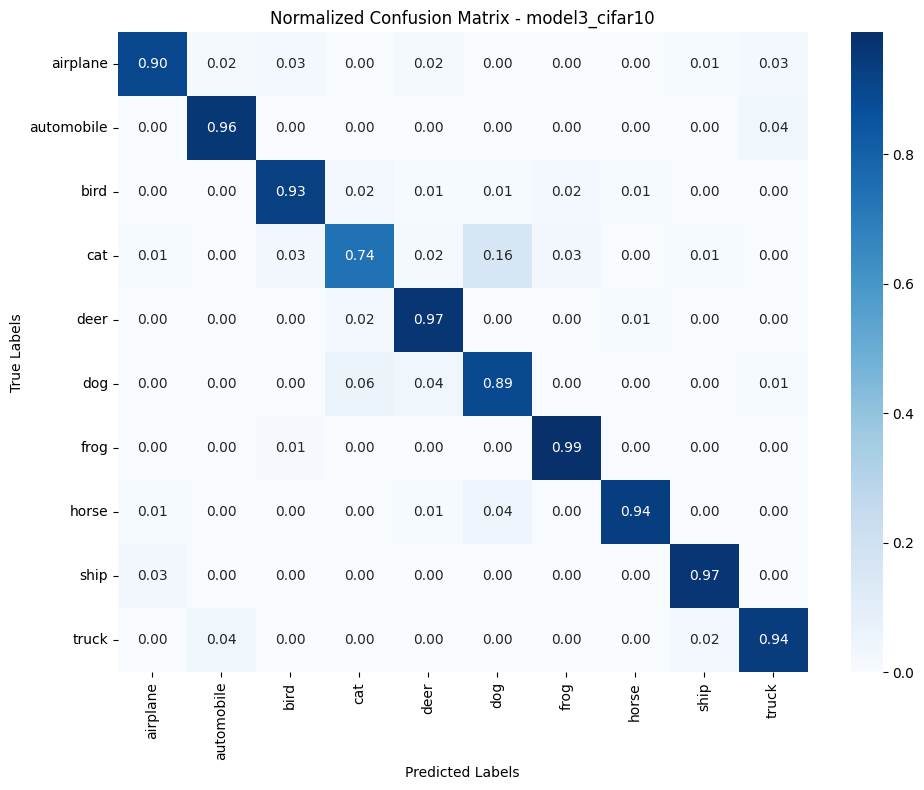


Evaluating normalized confusion matrix for efficientnetb7_cifar10...


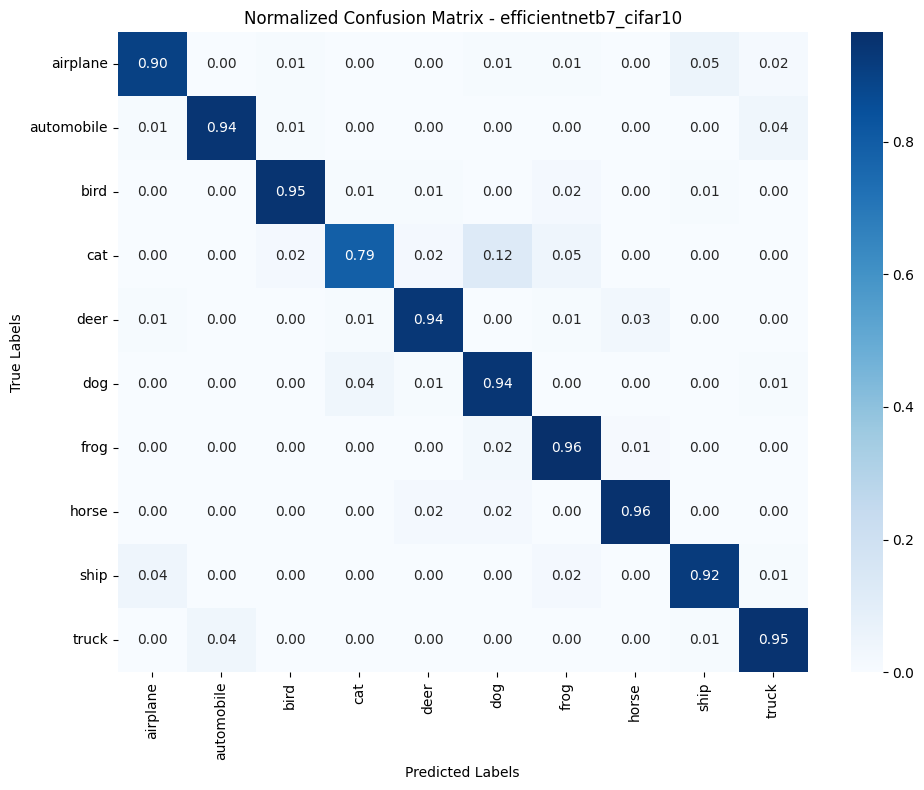


Evaluating normalized confusion matrix for resnet50_cifar10...


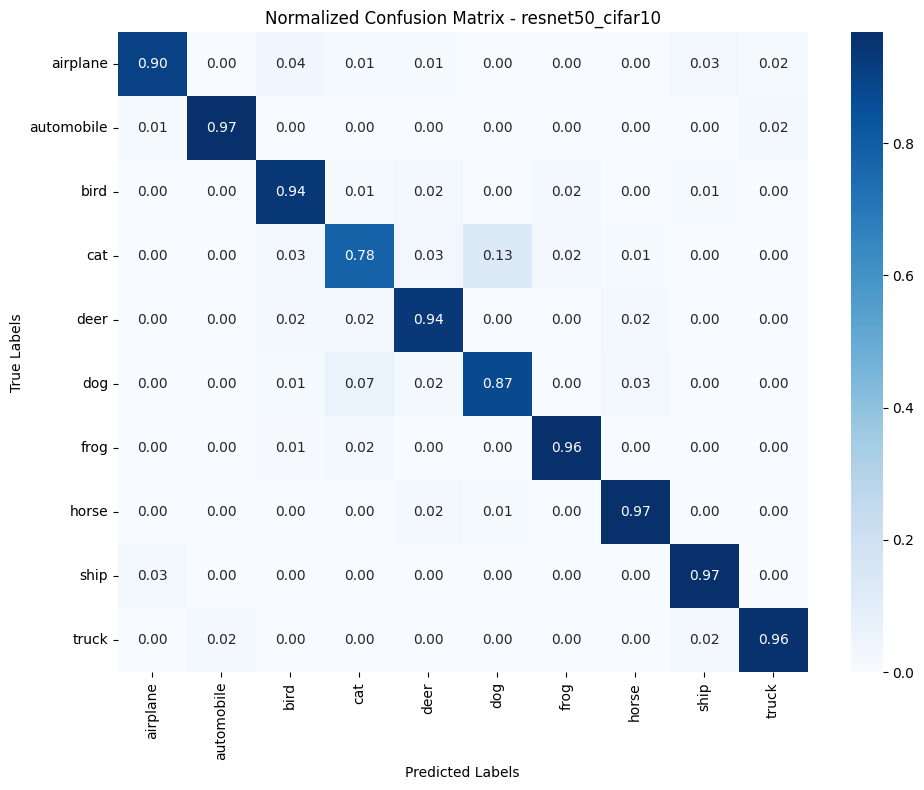

In [45]:
# CIFAR-10 test set subset for confusion matrices
ds_test, ds_info = tfds.load(
    'cifar10',
    split='test',
    with_info=True,
    as_supervised=True
)
class_names = ds_info.features['label'].names

# Take a subset of the test set for faster confusion matrix computation
test_subset = ds_test.take(1000)
x_test_raw, y_test = [], []

for img, label in test_subset:
    x_test_raw.append(img)
    y_test.append(label.numpy())

x_test_raw = tf.stack(x_test_raw)
y_test = np.array(y_test)

for name, path in cifar10_model_paths.items():
    # Check we have a preprocessing function
    if name not in cifar10_preprocess_map:
        print(f"Skipping {name}: no preprocessing function defined.")
        continue

    # Check model file exists
    if not os.path.exists(path):
        print(f"Skipping {name}: model file not found at: {path}")
        continue

    print(f"\nEvaluating normalized confusion matrix for {name}...")
    model = load_model(path)
    preprocess_fn = cifar10_preprocess_map[name]

    # Reuse the same helper as CIFAR-100
    y_pred = get_model_predictions(model, preprocess_fn, x_test_raw)

    cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
    cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_norm,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        annot=True,
        fmt=".2f",
    )
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
